# 随机森林 Random Forest
随机森林就是通过集成学习的思想将多棵树集成的一种算法，它的基本单元是决策树，而它的本质属于机器学习中的集成学习（Ensemble Learning）中的bagging方法。

## 随机森林的特点
- 具有极好的准确率
- 能够有效地运行在大数据集上
- 能够处理具有高维特征的输入样本，而且不需要降维
- 能够评估各个特征在分类问题上的重要性
- 在生成过程中，能够获取到内部生成误差的一种无偏估计
- 对于缺省值问题也能够获得很好得结果

## 随机森林的生成
我们要将一个输入样本进行分类，我们需要将输入样本输入到每棵树中进行分类，每棵树都要投票，要依据投票情况来确定，获得票数最多的类别就是森林的分类结果。将若干个弱分类器的分类结果进行投票选择，从而组成一个强分类器，这就是随机森林bagging的思想。
### 生成过程：
1. 如果训练集大小为N，对于`每棵树`而言，随机且`有放回`地从训练集中的抽取N个训练样本（这种采样方式称为bootstrap sample方法），作为该树的训练集;
2. 如果每个样本的特征维度为M，指定一个常数m<<M，`随机地从M个特征中选取m个特征子集`，每次树进行分裂时，从这m个特征中选择最优的；
3. 每棵树都尽最大程度的生长，并且`没有剪枝过程`。

## 简单实现
数据集用的是之前的氨基酸数据集，基于scikit-learn实现

In [1]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from tkinter import _flatten
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, accuracy_score

### one-hot型特征
将每个字符转化为20维的one-hot向量，再将8个向量拼接起来。

In [2]:
x_dict = {}
x_string = 'ARNDCQEGHILKMFPSTWYV'
for i in range(len(x_string)):
    key = x_string[i]
    x_vector = np.zeros(20)
    x_vector[i] = 1
    x_dict[key] = list(x_vector)
    
y_dict = {1:1, -1:0}

In [3]:
def read_file(file):
    data_x = []
    data_y = []
    with open(file) as f:
        for line in f.readlines():
            x, y = line.strip().split(',')
            x_list = [x_dict[i] for i in x]
            x_flatten_list = list(_flatten(x_list))
            data_x.append(x_flatten_list)
            data_y.append(int(y))
            
    return data_x, data_y

### 读取所有文件

In [4]:
file_765 = './newHIV-1_data/746Data.txt'
file_1625 = './newHIV-1_data/1625Data.txt'
file_impens = './newHIV-1_data/impensData.txt'
file_schilling = './newHIV-1_data/schillingData.txt'

data_765_x, data_765_y = read_file(file_765)
data_1625_x, data_1625_y = read_file(file_1625)
data_impens_x, data_impens_y = read_file(file_impens)
data_schilling_x, data_schilling_y = read_file(file_schilling)

data_dict_x = {}
data_dict_y = {}
data_dict_x['765'], data_dict_y['765'] = data_765_x, data_765_y
data_dict_x['1625'], data_dict_y['1625'] = data_1625_x, data_1625_y
data_dict_x['impens'], data_dict_y['impens'] = data_impens_x, data_impens_y
data_dict_x['schilling'], data_dict_y['schilling'] = data_schilling_x, data_schilling_y

data_set = ['765', '1625', 'impens', 'schilling']

### 随机森林函数（参数说明）
- **n_estimators：森林里（决策）树的数目。**
- criterion：衡量分裂质量的性能（函数）。 受支持的标准是基尼不纯度的"gini",和信息增益的"entropy"（熵）。
- max_depth：（决策）树的最大深度。如果值为None，那么会扩展节点，直到所有的叶子是纯净的，或者直到所有叶子包含少于min_sample_split的样本。
- min_samples_split：分割内部节点所需要的最小样本数量。
- **min_samples_leaf：需要在叶子结点上的最小样本数量。**
- min_weight_fraction_leaf：一个叶子节点所需要的权重总和（所有的输入样本）的最小加权分数。当sample_weight没有提供时，样本具有相同的权重。
- **max_features：寻找最佳分割时需要考虑的特征数目：**
    - **如果是int，就要考虑每一次分割处的max_feature特征**
    - **如果是float，那么max_features就是一个百分比，那么（max_feature*n_features）特征整数值是在每个分割处考虑的。**
    - **如果是auto，那么max_features=sqrt(n_features)，即n_features的平方根值。**
    - **如果是log2，那么max_features=log2(n_features)**
    - **如果是None,那么max_features=n_features**
- max_leaf_nodes：如果为None,那么不限制叶子节点的数量。
- min_impurity_decrease：如果节点的分裂导致的不纯度的下降程度大于或者等于这个节点的值，那么这个节点将会被分裂。
- min_impurity_split：树早期生长的阈值。如果一个节点的不纯度超过阈值那么这个节点将会分裂，否则它还是一片叶子。
- bootstrap：建立决策树时，是否使用有放回抽样。
- oob_score：是否使用袋外样本来估计泛化精度。
- n_jobs：用于拟合和预测的并行运行的工作（作业）数量。如果值为-1，那么工作数量被设置为核的数量。
- random_state：随机数生成器使用的种子。
- verbose：控制决策树建立过程的冗余度。
- warm_start：当被设置为True时，重新使用之前呼叫的解决方案，用来给全体拟合和添加更多的估计器，反之，仅仅只是为了拟合一个全新的森林。
- class_weight：相关联的类的可选的权值。

In [79]:
def random_forest(training_set, dataset, data_dict_x, data_dict_y):
    testing_set = dataset[:]
    testing_set.remove(training_set)
    x_train, y_train = data_dict_x[training_set], data_dict_y[training_set]
    x_test, y_test = data_dict_x[testing_set[0]], data_dict_y[testing_set[0]]
    for i in range(2):
        x_test = x_test + data_dict_x[testing_set[i+1]]
        y_test = y_test + data_dict_y[testing_set[i+1]]
    
    clf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1,
                                 min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0,
                                 min_impurity_split=None, bootstrap=True, oob_score=True, n_jobs=1, random_state=None, verbose=0, 
                                 warm_start=False, class_weight=None)

    clf.fit(x_train, y_train)
    
    y_pred = clf.predict(x_test)
    report = classification_report(y_test, y_pred)

    auc = roc_auc_score(y_test, y_pred)
    
    oob_score = clf.oob_score_
    print("report: ", report)
    print("auc: ", auc)
    print("oob_score: ", oob_score)

### 分别以一个数据集作为训练集并在其他三个数据集上做测试

In [80]:
training_set = '765'
random_forest(training_set, data_set, data_dict_x, data_dict_y)

report:                precision    recall  f1-score   support

          -1       0.94      0.88      0.91      4886
           1       0.53      0.73      0.62       958

   micro avg       0.85      0.85      0.85      5844
   macro avg       0.74      0.80      0.76      5844
weighted avg       0.88      0.85      0.86      5844

auc:  0.802603963264305
oob_score:  0.9115281501340483


In [81]:
training_set = '1625'
random_forest(training_set, data_set, data_dict_x, data_dict_y)

report:                precision    recall  f1-score   support

          -1       0.88      0.99      0.93      3980
           1       0.93      0.44      0.60       985

   micro avg       0.88      0.88      0.88      4965
   macro avg       0.90      0.71      0.76      4965
weighted avg       0.89      0.88      0.86      4965

auc:  0.7147616253858123
oob_score:  0.9427692307692308


In [82]:
training_set = 'impens'
random_forest(training_set, data_set, data_dict_x, data_dict_y)

report:                precision    recall  f1-score   support

          -1       0.82      0.96      0.89      4432
           1       0.64      0.23      0.34      1211

   micro avg       0.81      0.81      0.81      5643
   macro avg       0.73      0.60      0.61      5643
weighted avg       0.78      0.81      0.77      5643

auc:  0.597069078721825
oob_score:  0.8627243928194298


In [83]:
training_set = 'schilling'
random_forest(training_set, data_set, data_dict_x, data_dict_y)

report:                precision    recall  f1-score   support

          -1       0.77      0.98      0.86      2392
           1       0.83      0.23      0.36       926

   micro avg       0.77      0.77      0.77      3318
   macro avg       0.80      0.61      0.61      3318
weighted avg       0.79      0.77      0.72      3318

auc:  0.6074333451317206
oob_score:  0.9058679706601467


### max_features特征的影响

In [10]:
'''
m: max_features特征，int类型
'''
def random_forest_m(training_set, dataset, data_dict_x, data_dict_y, m):
    testing_set = dataset[:]
    testing_set.remove(training_set)
    x_train, y_train = data_dict_x[training_set], data_dict_y[training_set]
    x_test, y_test = data_dict_x[testing_set[0]], data_dict_y[testing_set[0]]
    for i in range(2):
        x_test = x_test + data_dict_x[testing_set[i+1]]
        y_test = y_test + data_dict_y[testing_set[i+1]]
    
    clf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1,
                                 min_weight_fraction_leaf=0.0, max_features=m, max_leaf_nodes=None, min_impurity_decrease=0.0,
                                 min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, 
                                 warm_start=False, class_weight=None)

    clf.fit(x_train, y_train)
    
    y_pred = clf.predict(x_test)
    report = classification_report(y_test, y_pred)

    auc = roc_auc_score(y_test, y_pred)
    return auc

### 图像展示结果

In [11]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import seaborn as sns

Text(0, 0.5, 'AUC')

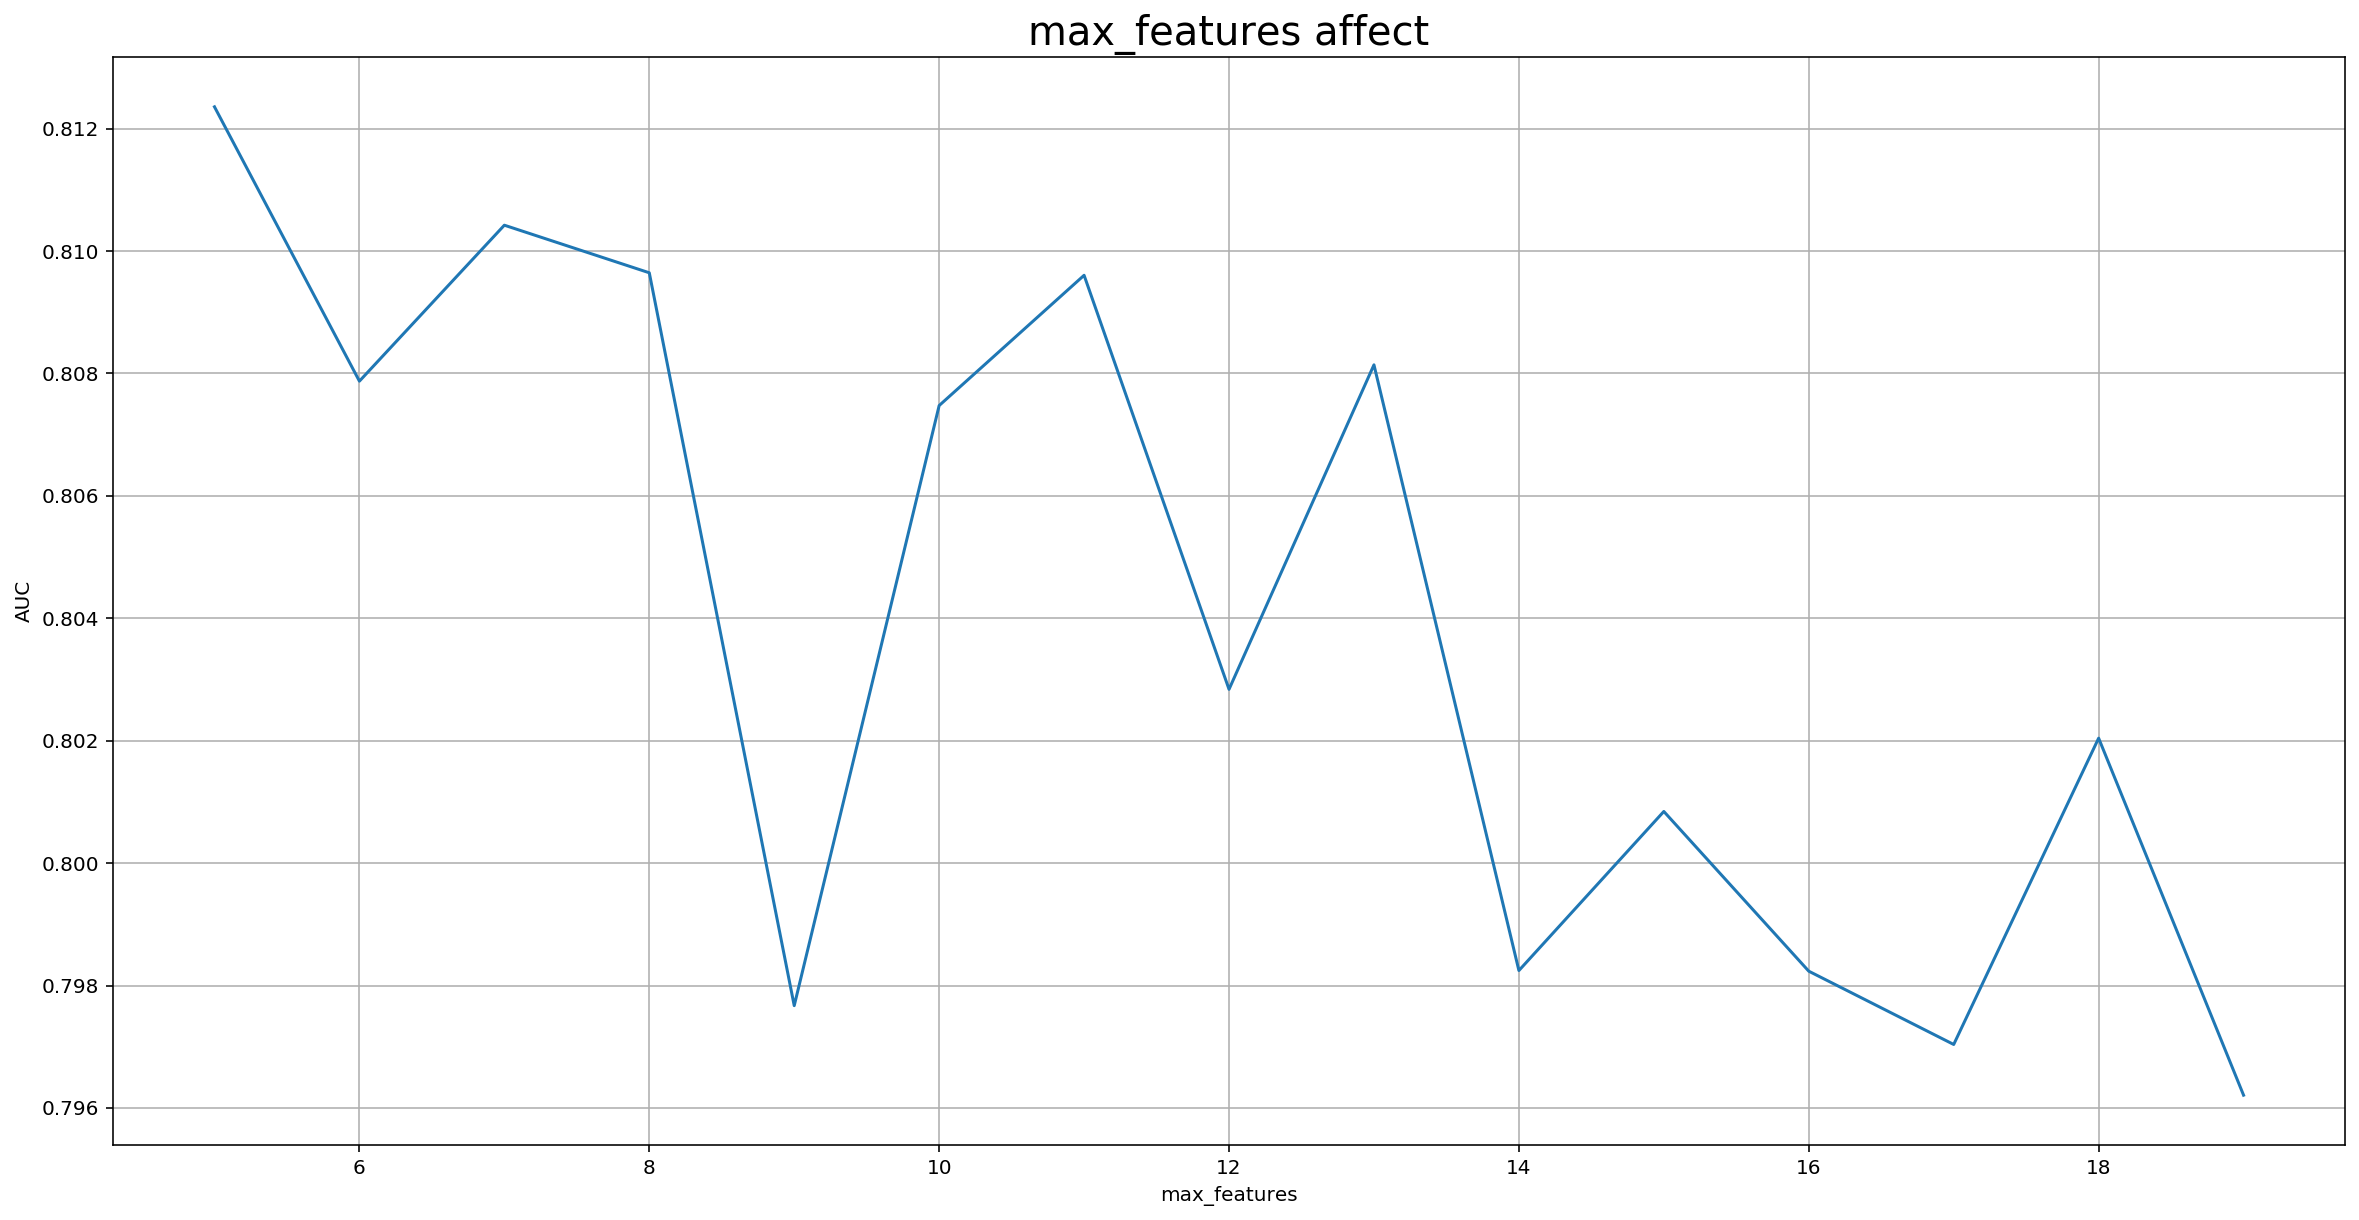

In [65]:
training_set = '765'
m_list = []
auc_list = []
for m in range(5, 20):
    auc = random_forest_m(training_set, data_set, data_dict_x, data_dict_y, m)
    m_list.append(m)
    auc_list.append(auc)

fig = plt.figure(figsize=(20, 10))
ax = plt.subplot(111)
plt.grid()
sns.lineplot(x=m_list, y=auc_list)
ax.set_title('max_features affect', fontsize=20)
ax.set_xlabel('max_features')
ax.set_ylabel('AUC')

#### 结果分析
默认参数‘auto’是取特征数量的开方值，本实验中特征数是160（20*8）个特征，即‘auto’=12-13之间，因此m的取值范围我取6-19。

结果发现当m取7时取得最佳效果，之后随着m的提升效果呈下降趋势。

### n_estimators的影响

In [62]:
'''
n: n_estimators特征，int类型
'''
def random_forest_n(training_set, dataset, data_dict_x, data_dict_y, n):
    testing_set = dataset[:]
    testing_set.remove(training_set)
    x_train, y_train = data_dict_x[training_set], data_dict_y[training_set]
    x_test, y_test = data_dict_x[testing_set[0]], data_dict_y[testing_set[0]]
    for i in range(2):
        x_test = x_test + data_dict_x[testing_set[i+1]]
        y_test = y_test + data_dict_y[testing_set[i+1]]
    
    clf = RandomForestClassifier(n_estimators=n, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1,
                                 min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0,
                                 min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, 
                                 warm_start=False, class_weight=None)

    clf.fit(x_train, y_train)
    
    y_pred = clf.predict(x_test)
    report = classification_report(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    return auc

Text(0.5, 0, 'n_estimators')

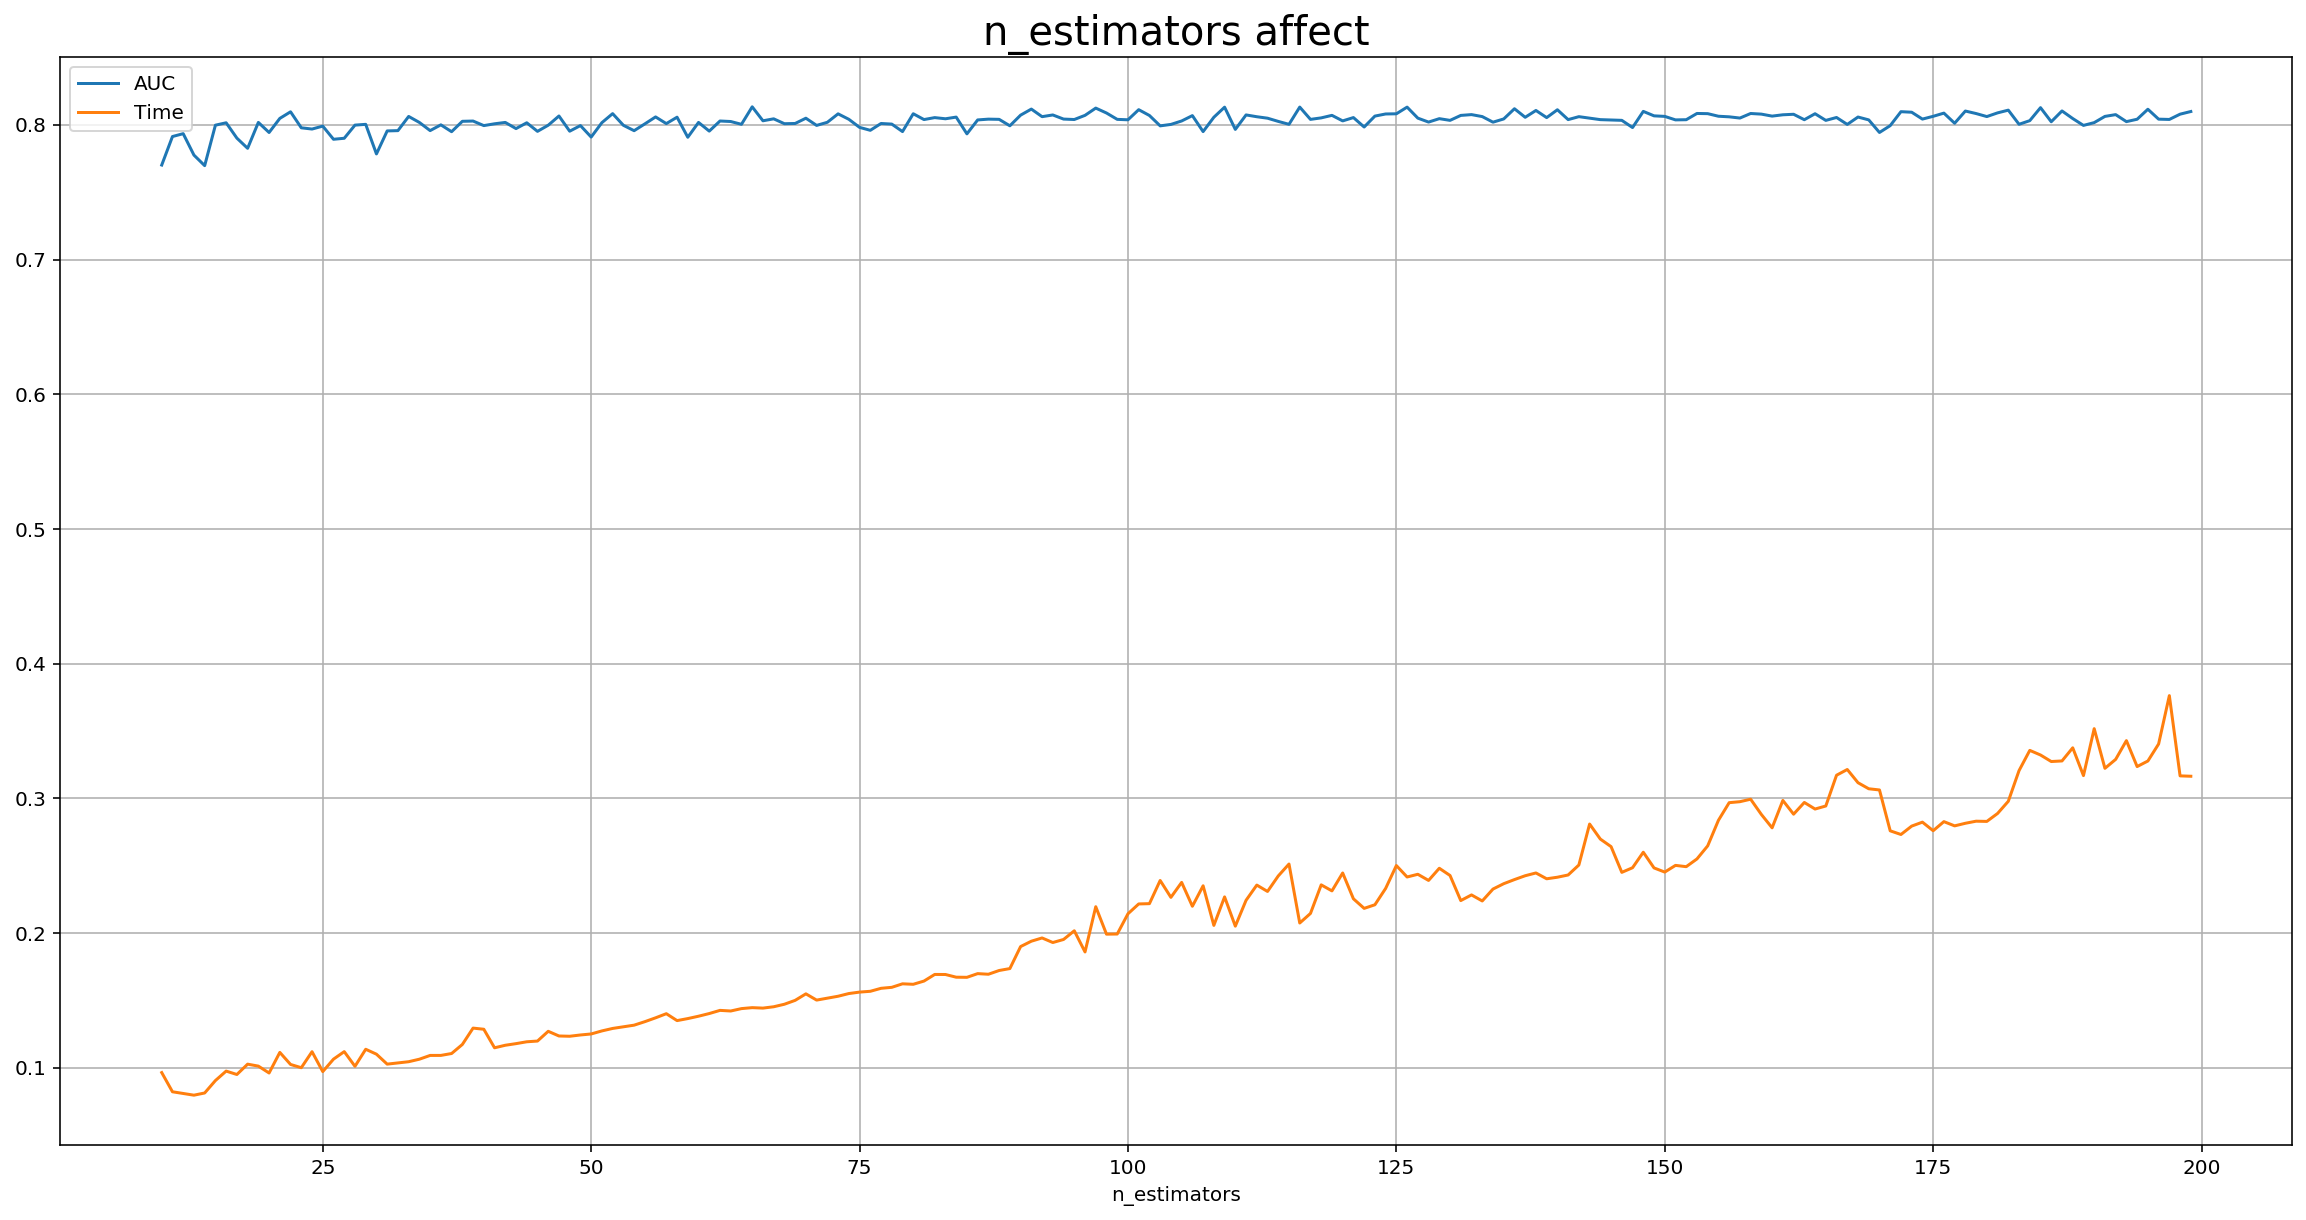

In [63]:
from time import time
training_set = '765'
n_list = []
auc_list = []
time_list = []
for n in range(10, 200):
    time1 = time()
    auc = random_forest_n(training_set, data_set, data_dict_x, data_dict_y, n)
    time2 = time()
    n_list.append(n)
    auc_list.append(auc)
    time_list.append(time2-time1)

fig = plt.figure(figsize=(20, 10))
ax = plt.subplot(111)
plt.grid()
sns.lineplot(x=n_list, y=auc_list, label='AUC')
sns.lineplot(x=n_list, y=time_list, label='Time')
ax.set_title('n_estimators affect', fontsize=20)
ax.set_xlabel('n_estimators')

Text(0.5, 0, 'n_estimators')

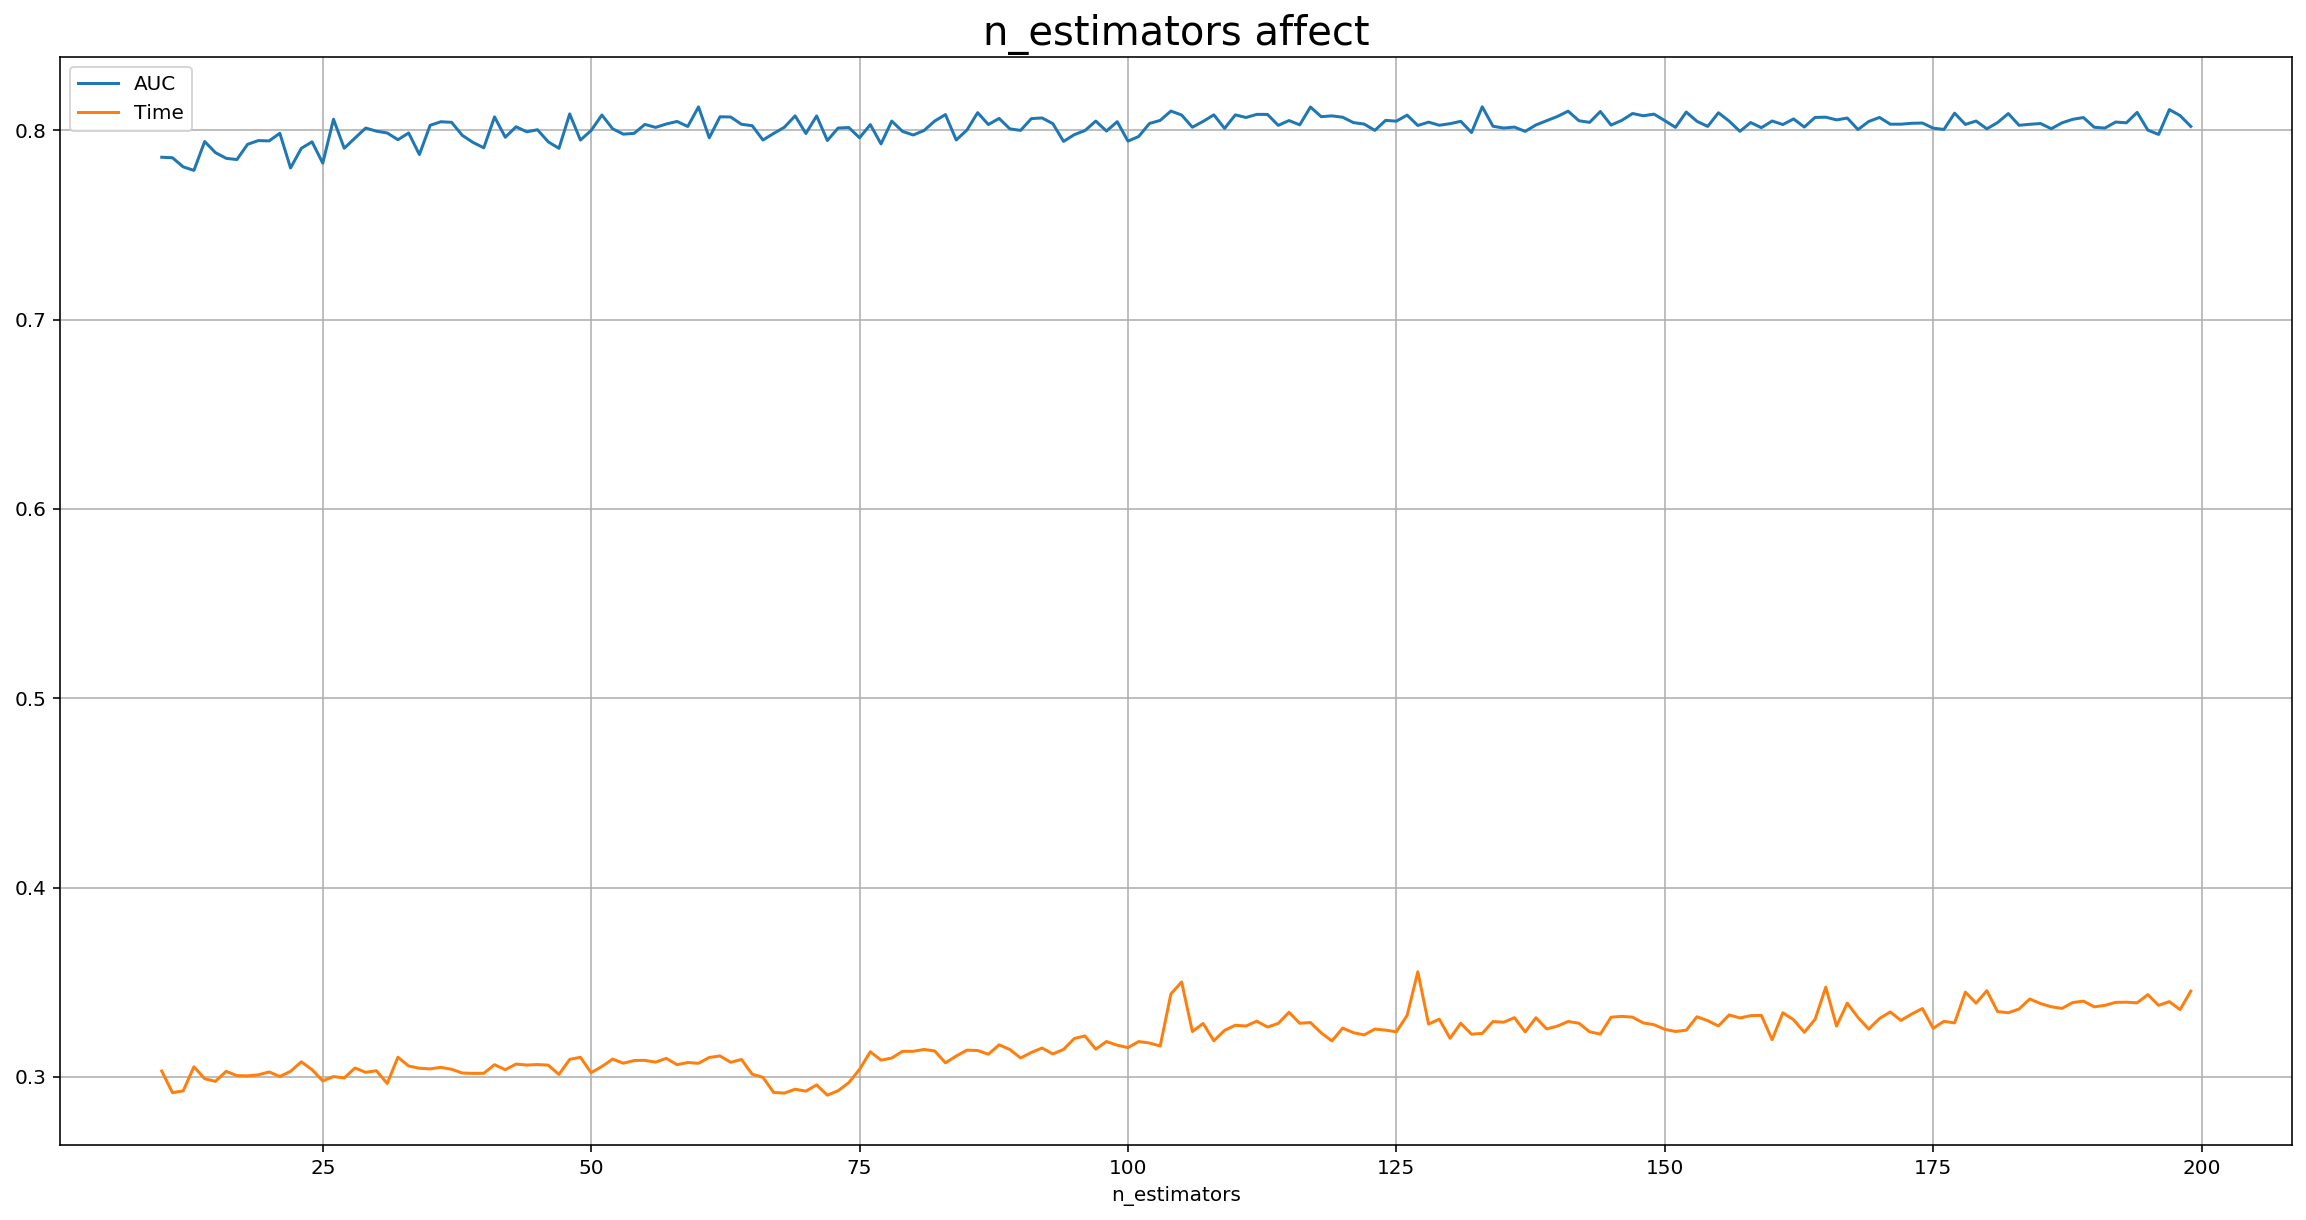

In [61]:
from time import time
training_set = '765'
n_list = []
auc_list = []
time_list = []
for n in range(10, 200):
    time1 = time()
    auc = random_forest_n(training_set, data_set, data_dict_x, data_dict_y, n)
    time2 = time()
    n_list.append(n)
    auc_list.append(auc)
    time_list.append(time2-time1)

fig = plt.figure(figsize=(20, 10))
ax = plt.subplot(111)
plt.grid()
sns.lineplot(x=n_list, y=auc_list, label='AUC')
sns.lineplot(x=n_list, y=time_list, label='Time')
ax.set_title('n_estimators affect', fontsize=20)
ax.set_xlabel('n_estimators')

#### 结果分析
n_estimators是随机森林中决策树的数量选择。

结果发现随决策树数量的提升效果整体呈上升趋势但是上升程度小。

同时模型消耗时间随决策树数量的增多而增多。但整体上来说100个决策树所用时间比10个决策树所用时间没有非常明显的增加。

### min_sample_leaf的影响

In [72]:
'''
msl: min_sample_leaf特征，int类型
'''
def random_forest_msl(training_set, dataset, data_dict_x, data_dict_y, msl):
    testing_set = dataset[:]
    testing_set.remove(training_set)
    x_train, y_train = data_dict_x[training_set], data_dict_y[training_set]
    x_test, y_test = data_dict_x[testing_set[0]], data_dict_y[testing_set[0]]
    for i in range(2):
        x_test = x_test + data_dict_x[testing_set[i+1]]
        y_test = y_test + data_dict_y[testing_set[i+1]]
    
    clf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=msl,
                                 min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0,
                                 min_impurity_split=None, bootstrap=True, oob_score=True, n_jobs=1, random_state=None, verbose=0, 
                                 warm_start=False, class_weight=None)

    clf.fit(x_train, y_train)
    
    y_pred = clf.predict(x_test)
    report = classification_report(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    oob = clf.oob_score_
    score = clf.score(x_test, y_test)
    return auc, oob, score

Text(0, 0.5, 'AUC')

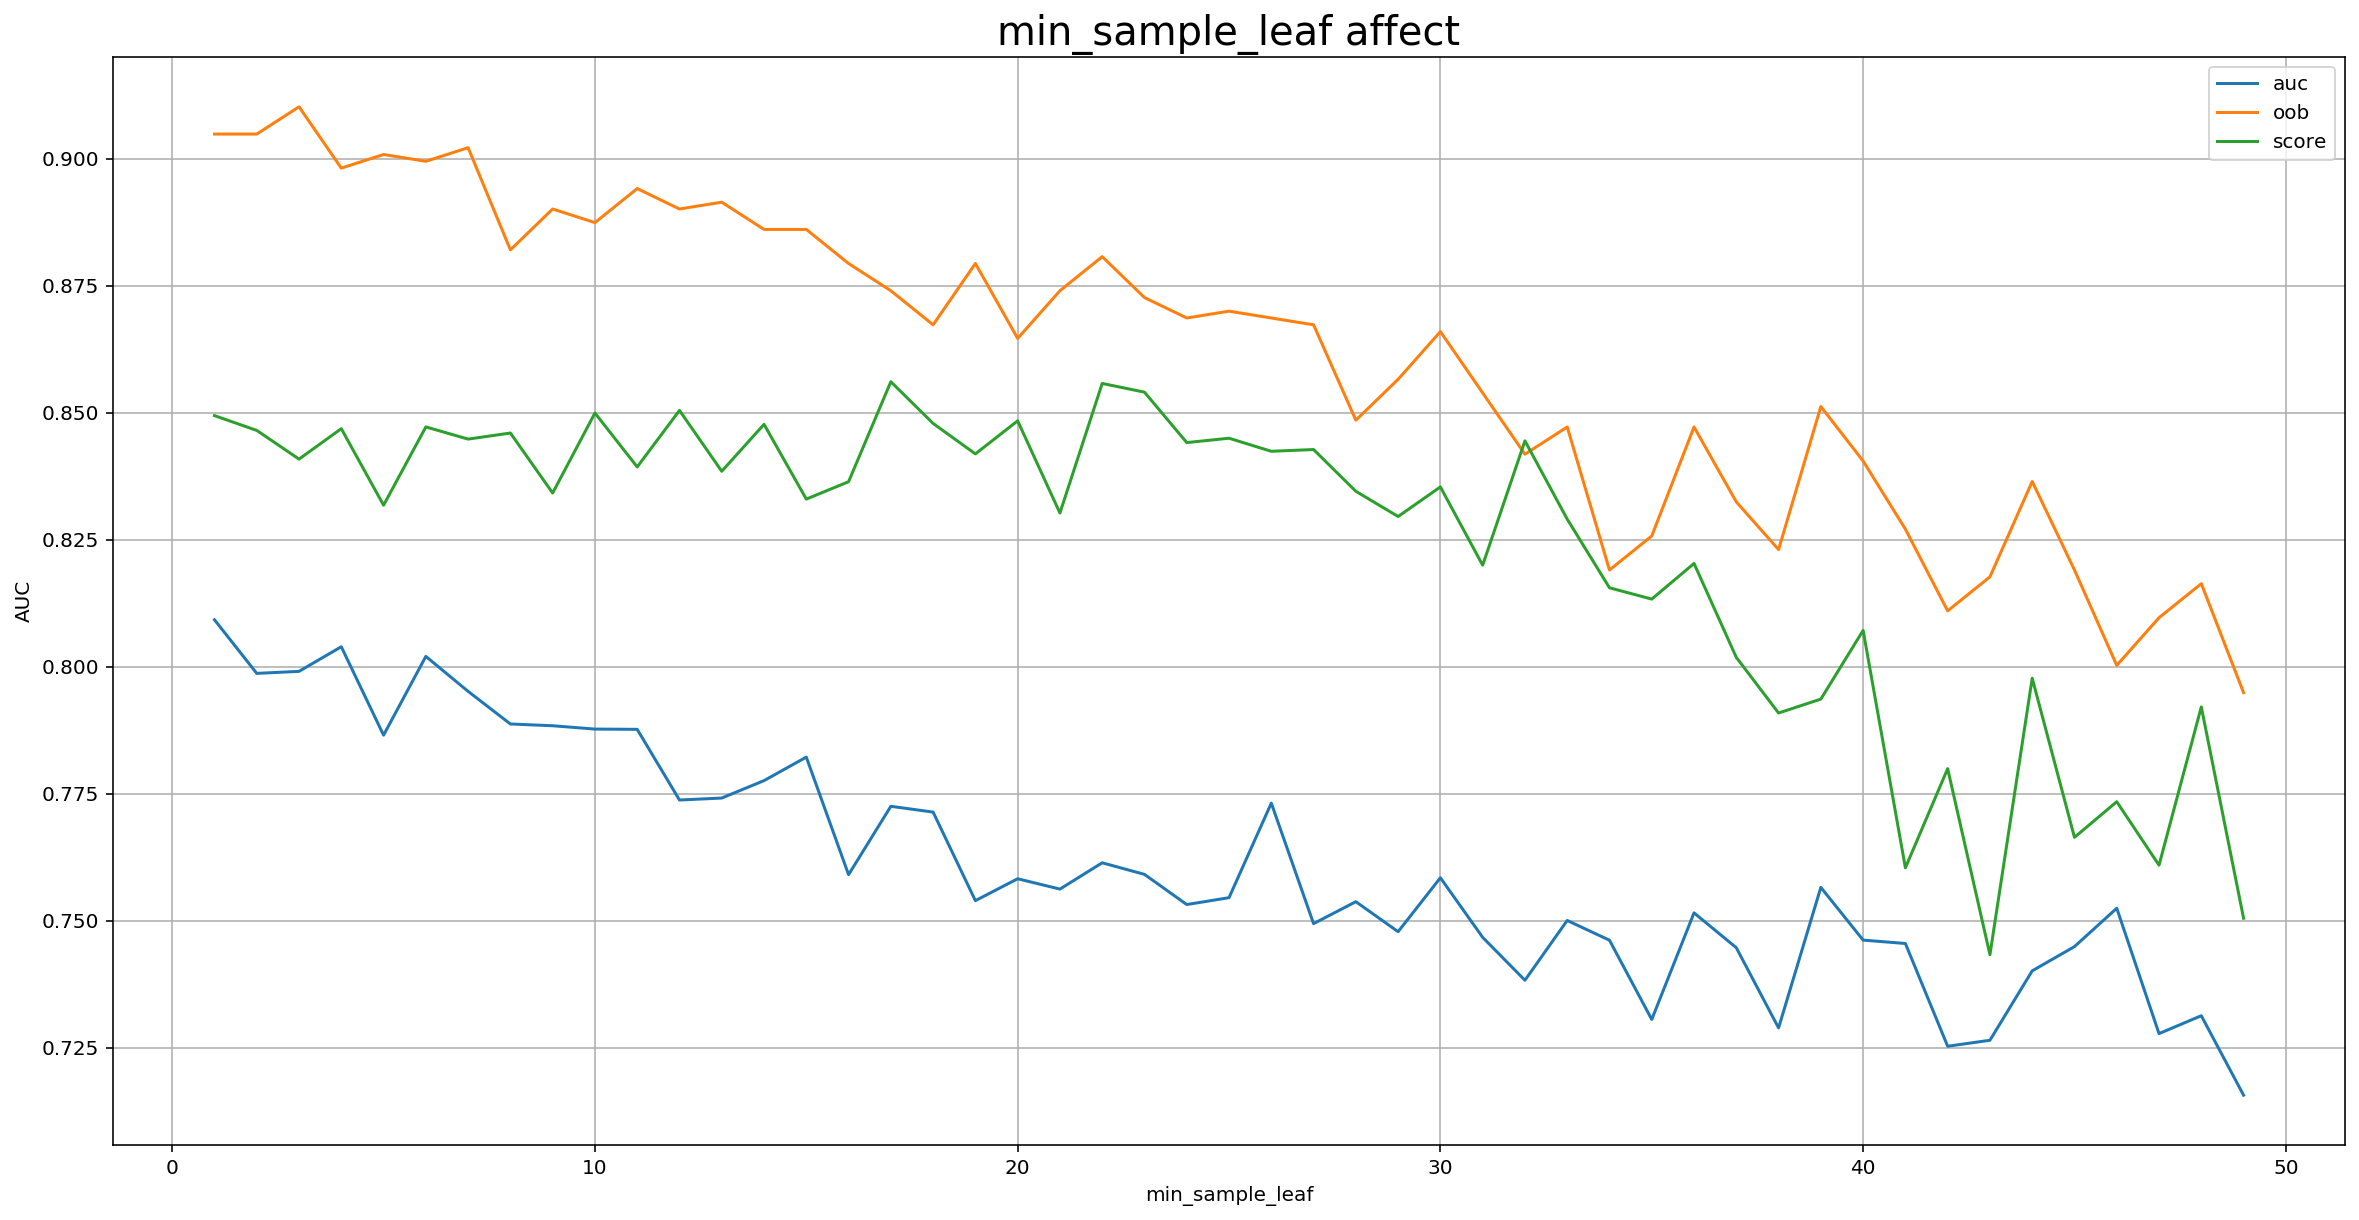

In [73]:
training_set = '765'
msl_list = []
auc_list = []
oob_list = []
score_list = []
for msl in range(1, 50):
    auc, oob, score = random_forest_msl(training_set, data_set, data_dict_x, data_dict_y, msl)
    msl_list.append(msl)
    auc_list.append(auc)
    oob_list.append(oob)
    score_list.append(score)

fig = plt.figure(figsize=(20, 10))
ax = plt.subplot(111)
plt.grid()
sns.lineplot(x=msl_list, y=auc_list, label='auc')
sns.lineplot(x=msl_list, y=oob_list, label='oob')
sns.lineplot(x=msl_list, y=score_list, label='score')
ax.set_title('min_sample_leaf affect', fontsize=20)
ax.set_xlabel('min_sample_leaf')
ax.set_ylabel('AUC')

#### 结果分析
对于这个任务来说，这个特征越小实验效果越好

### 特征重要性展示

In [16]:
feature_names = []
for i in range(8):
    for j in range(20):
        strr = str(i + 1) + '-' + str(j + 1)
        feature_names.append(strr)
# print(feature_names)

In [18]:
def random_forest_importance(training_set, dataset, data_dict_x, data_dict_y):
    testing_set = dataset[:]
    testing_set.remove(training_set)
    x_train, y_train = data_dict_x[training_set], data_dict_y[training_set]
    x_test, y_test = data_dict_x[testing_set[0]], data_dict_y[testing_set[0]]
    for i in range(2):
        x_test = x_test + data_dict_x[testing_set[i+1]]
        y_test = y_test + data_dict_y[testing_set[i+1]]
    
    clf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1,
                                 min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0,
                                 min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, 
                                 warm_start=False, class_weight=None)

    clf.fit(x_train, y_train)
    
    return clf.feature_importances_

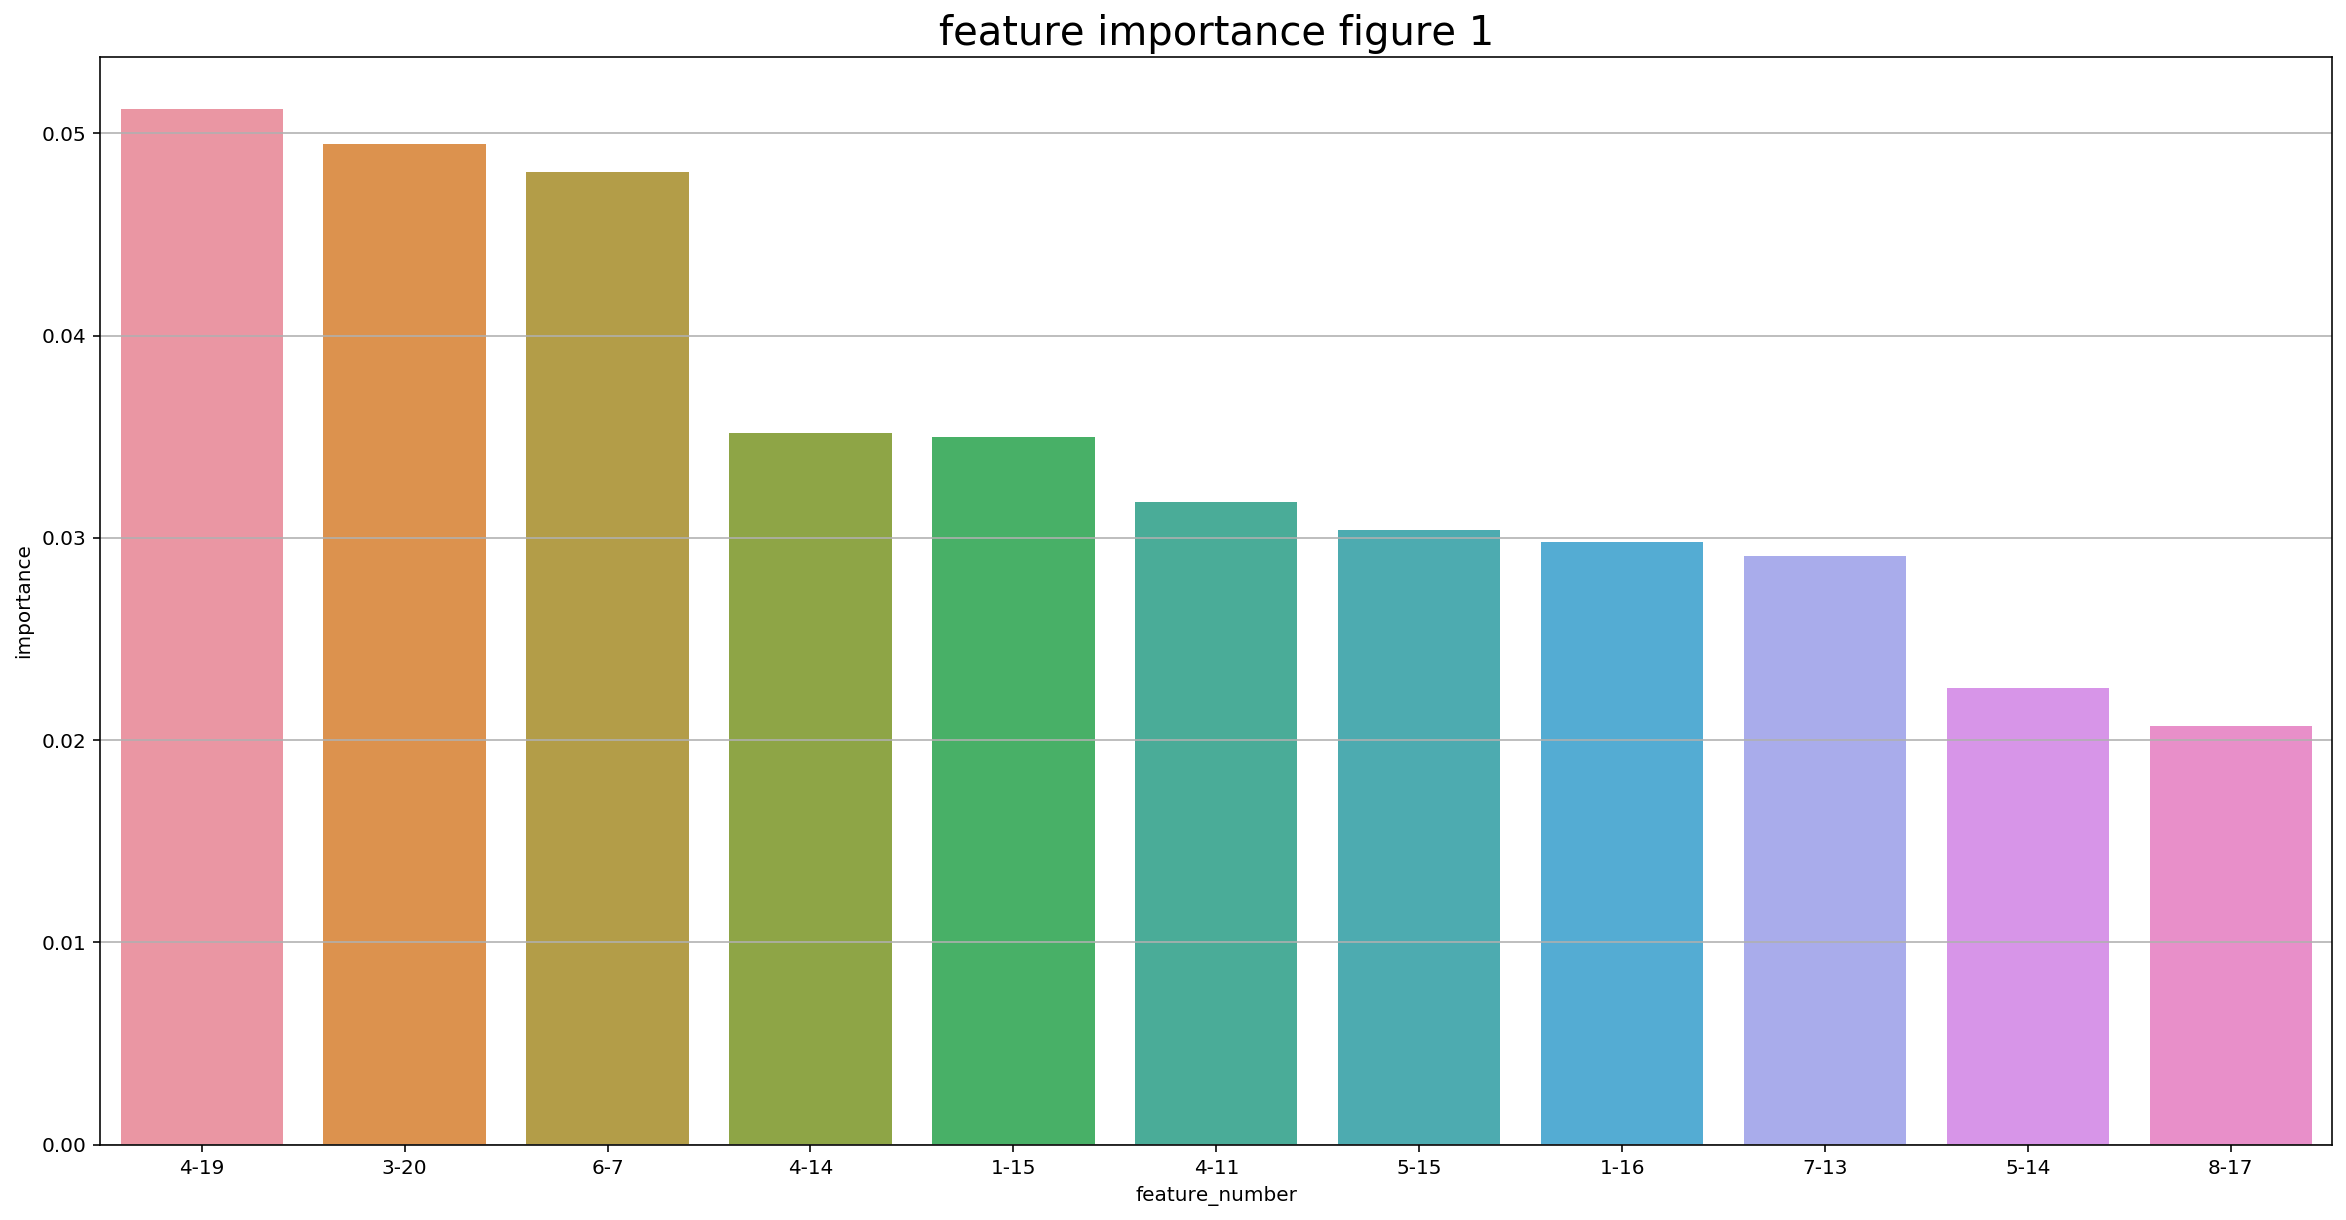

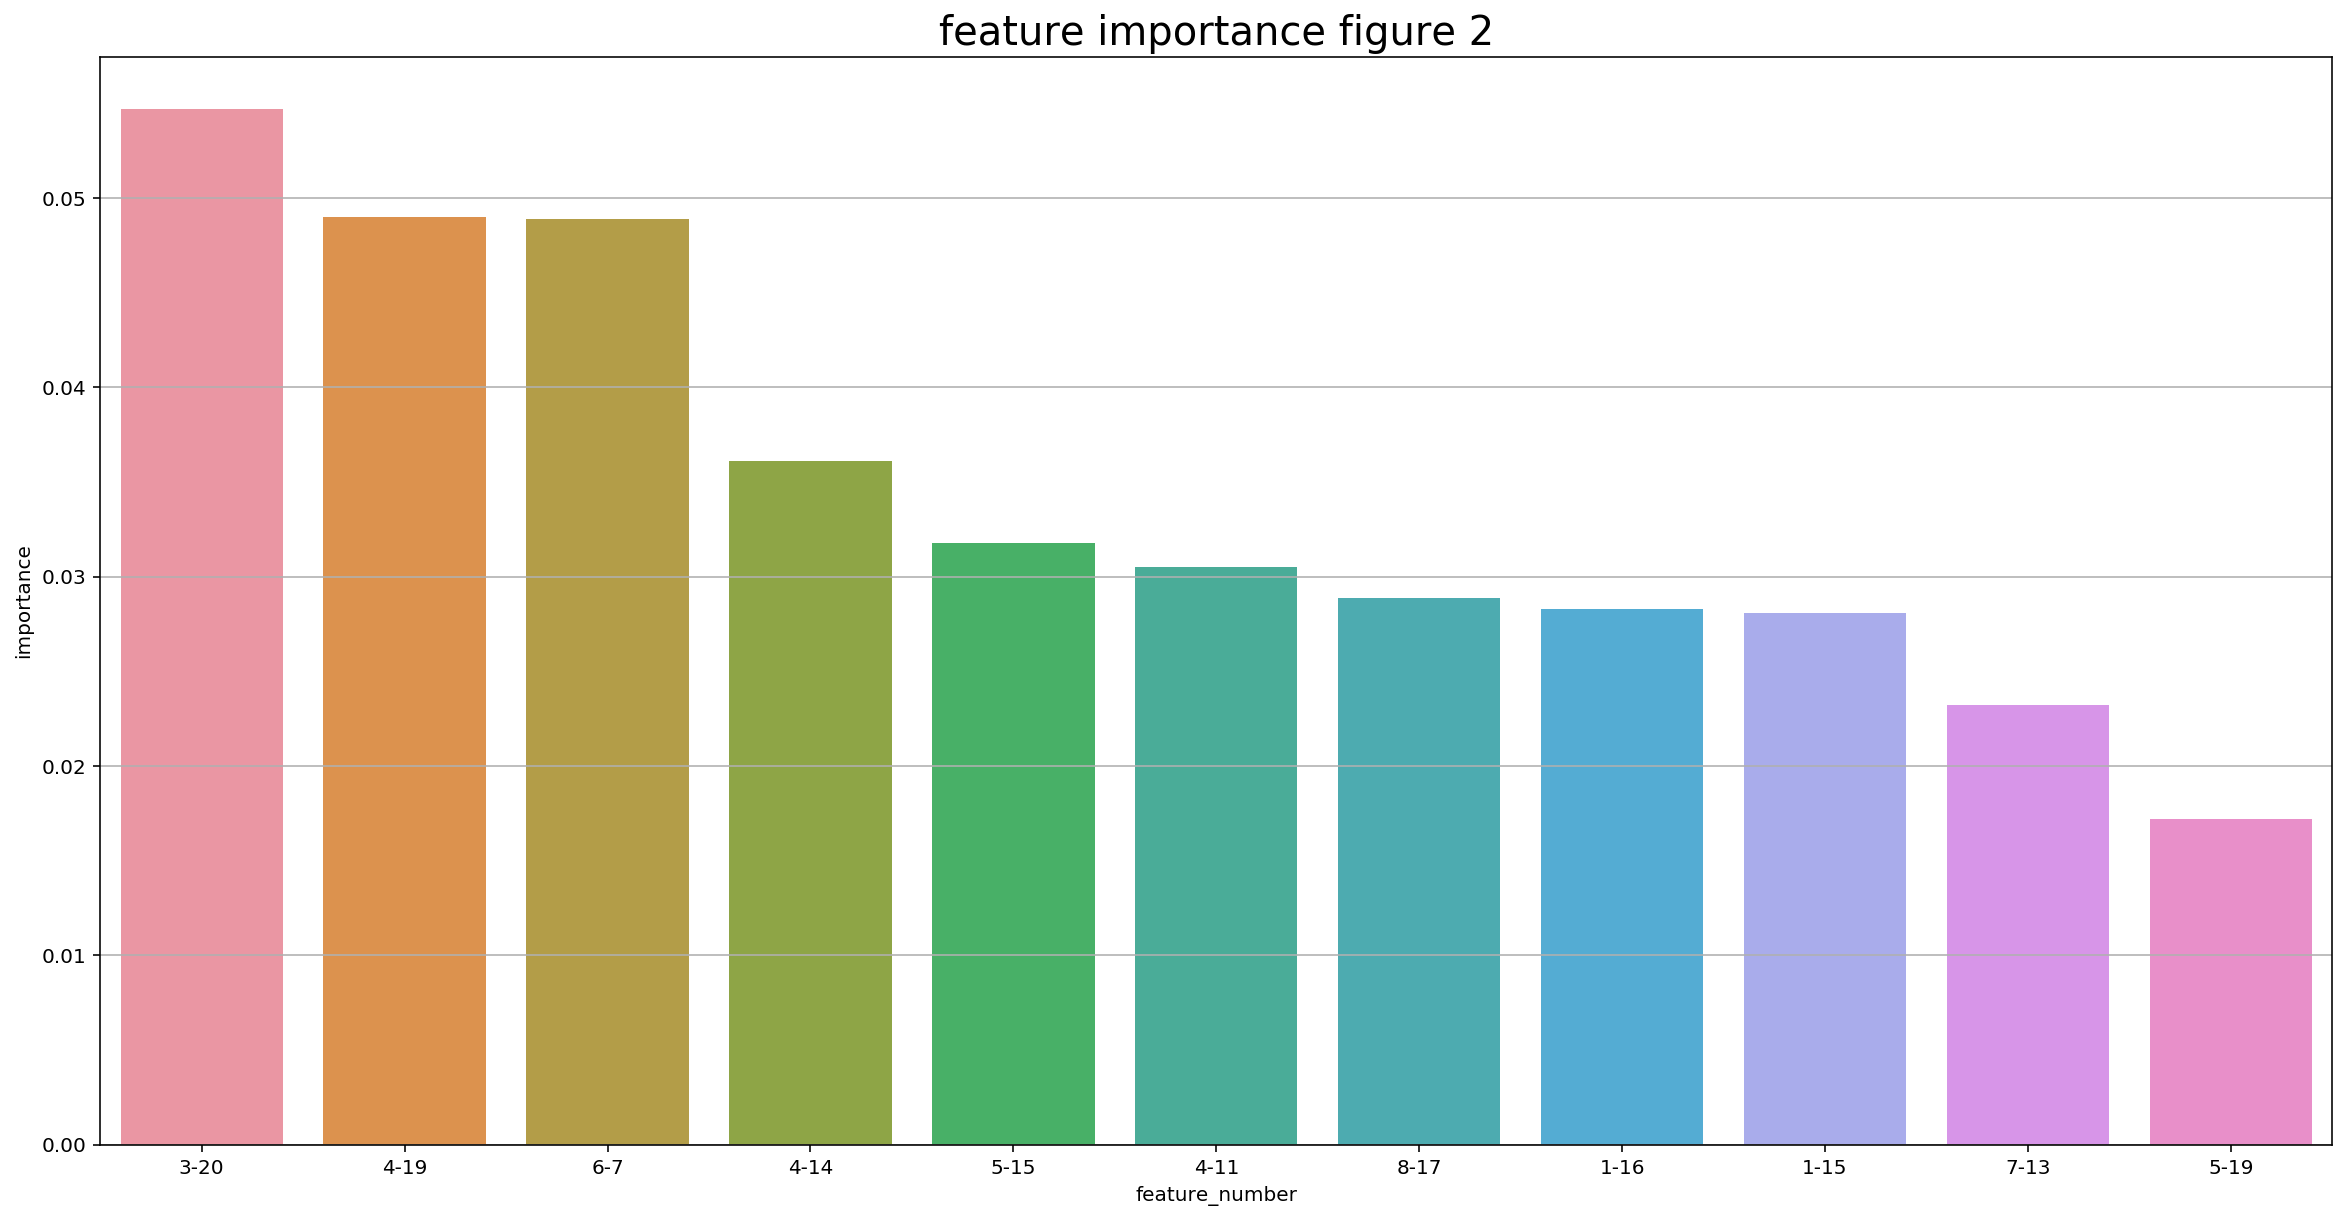

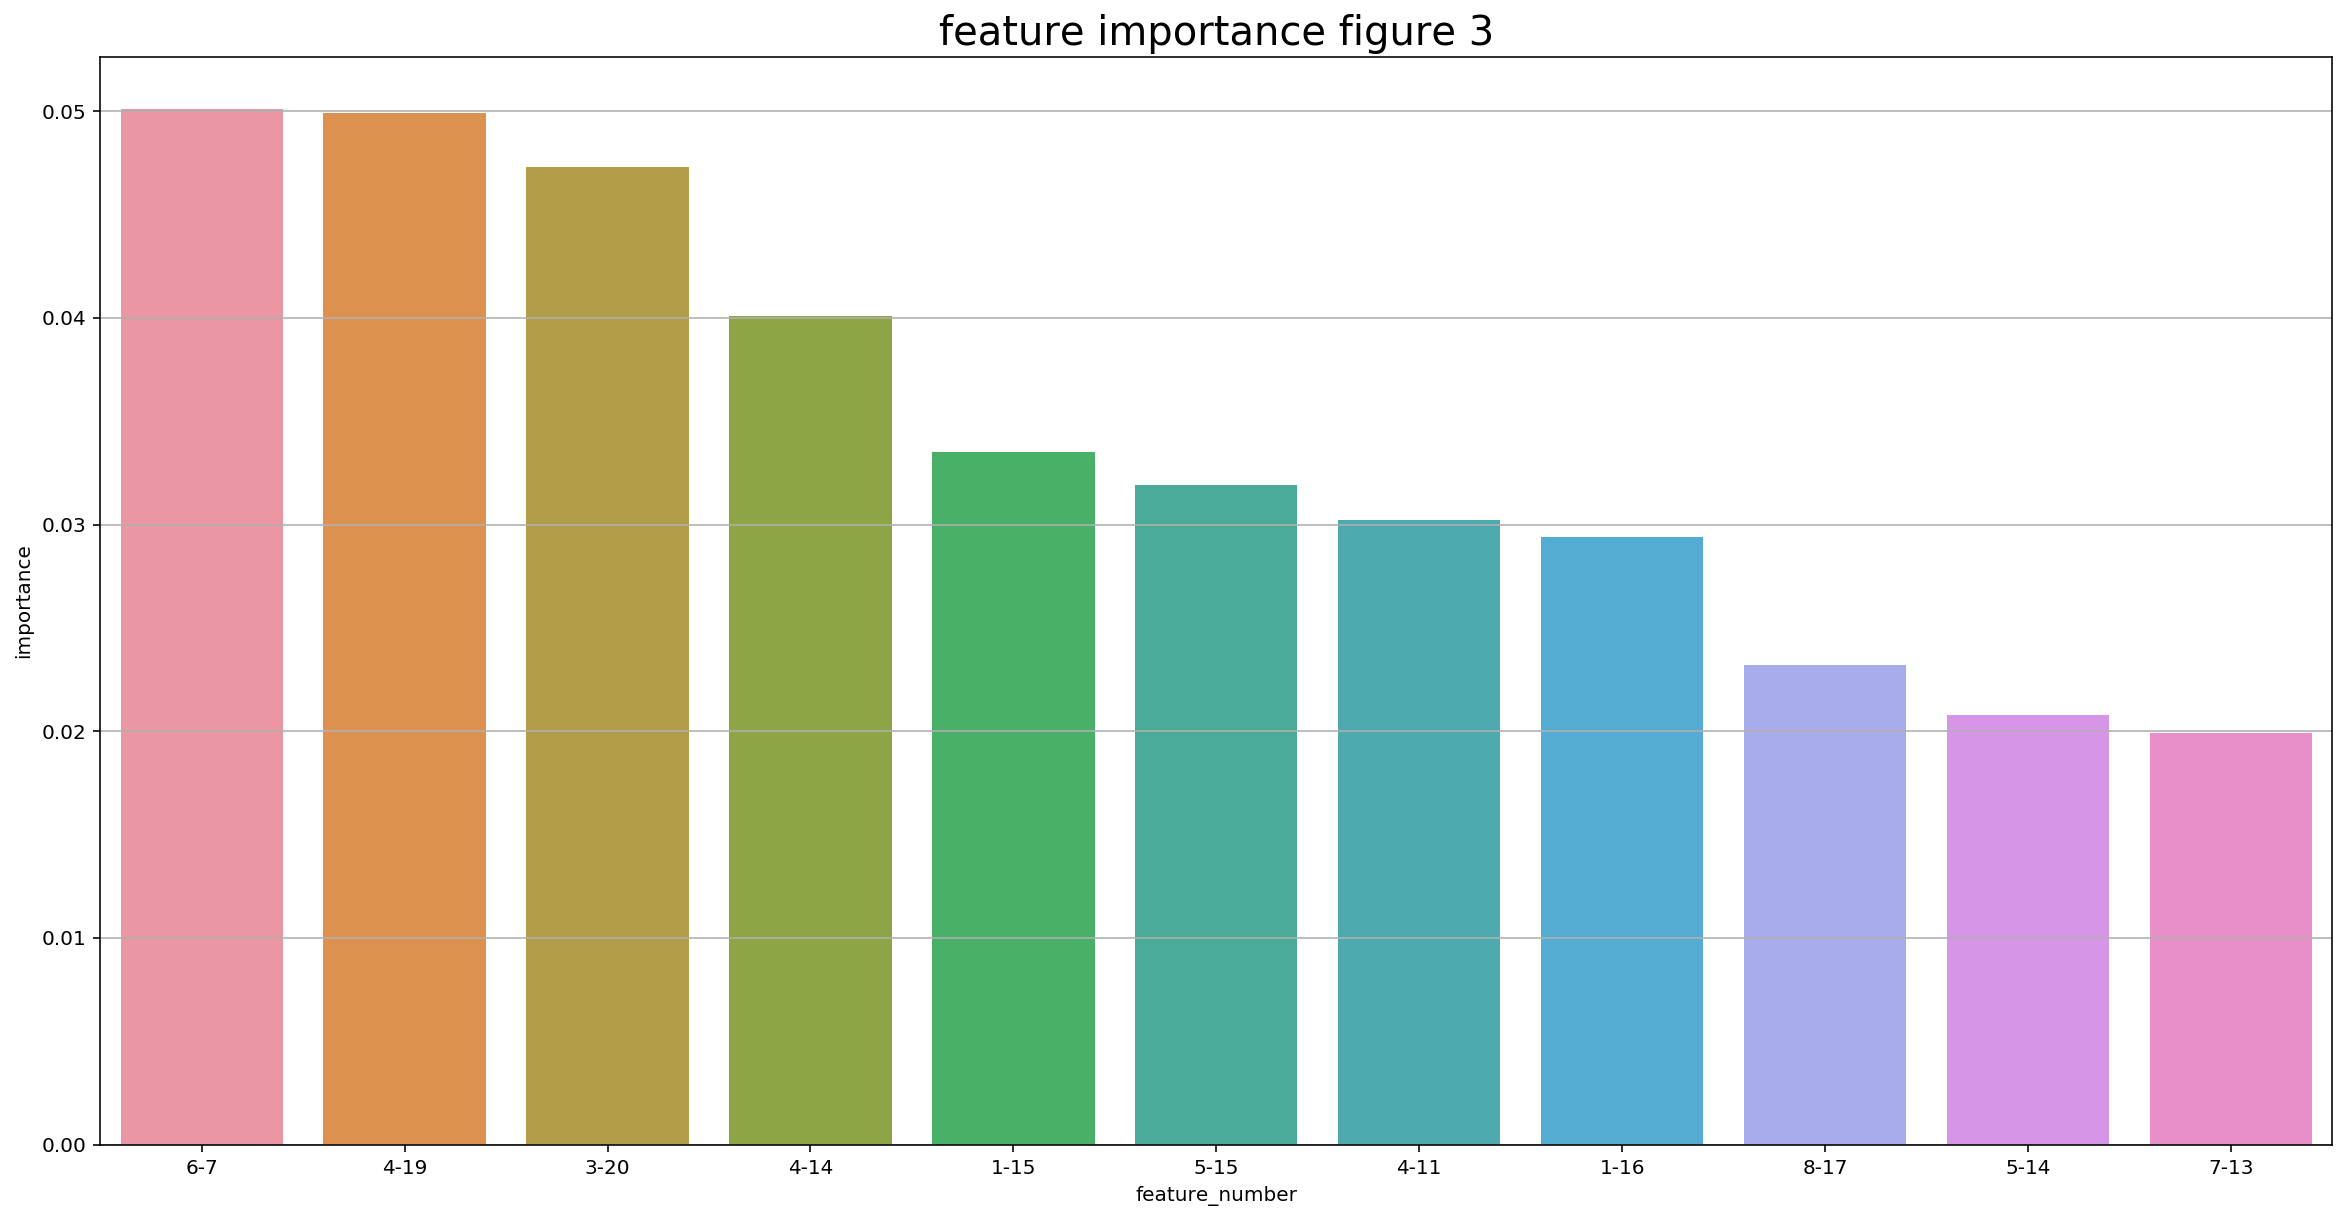

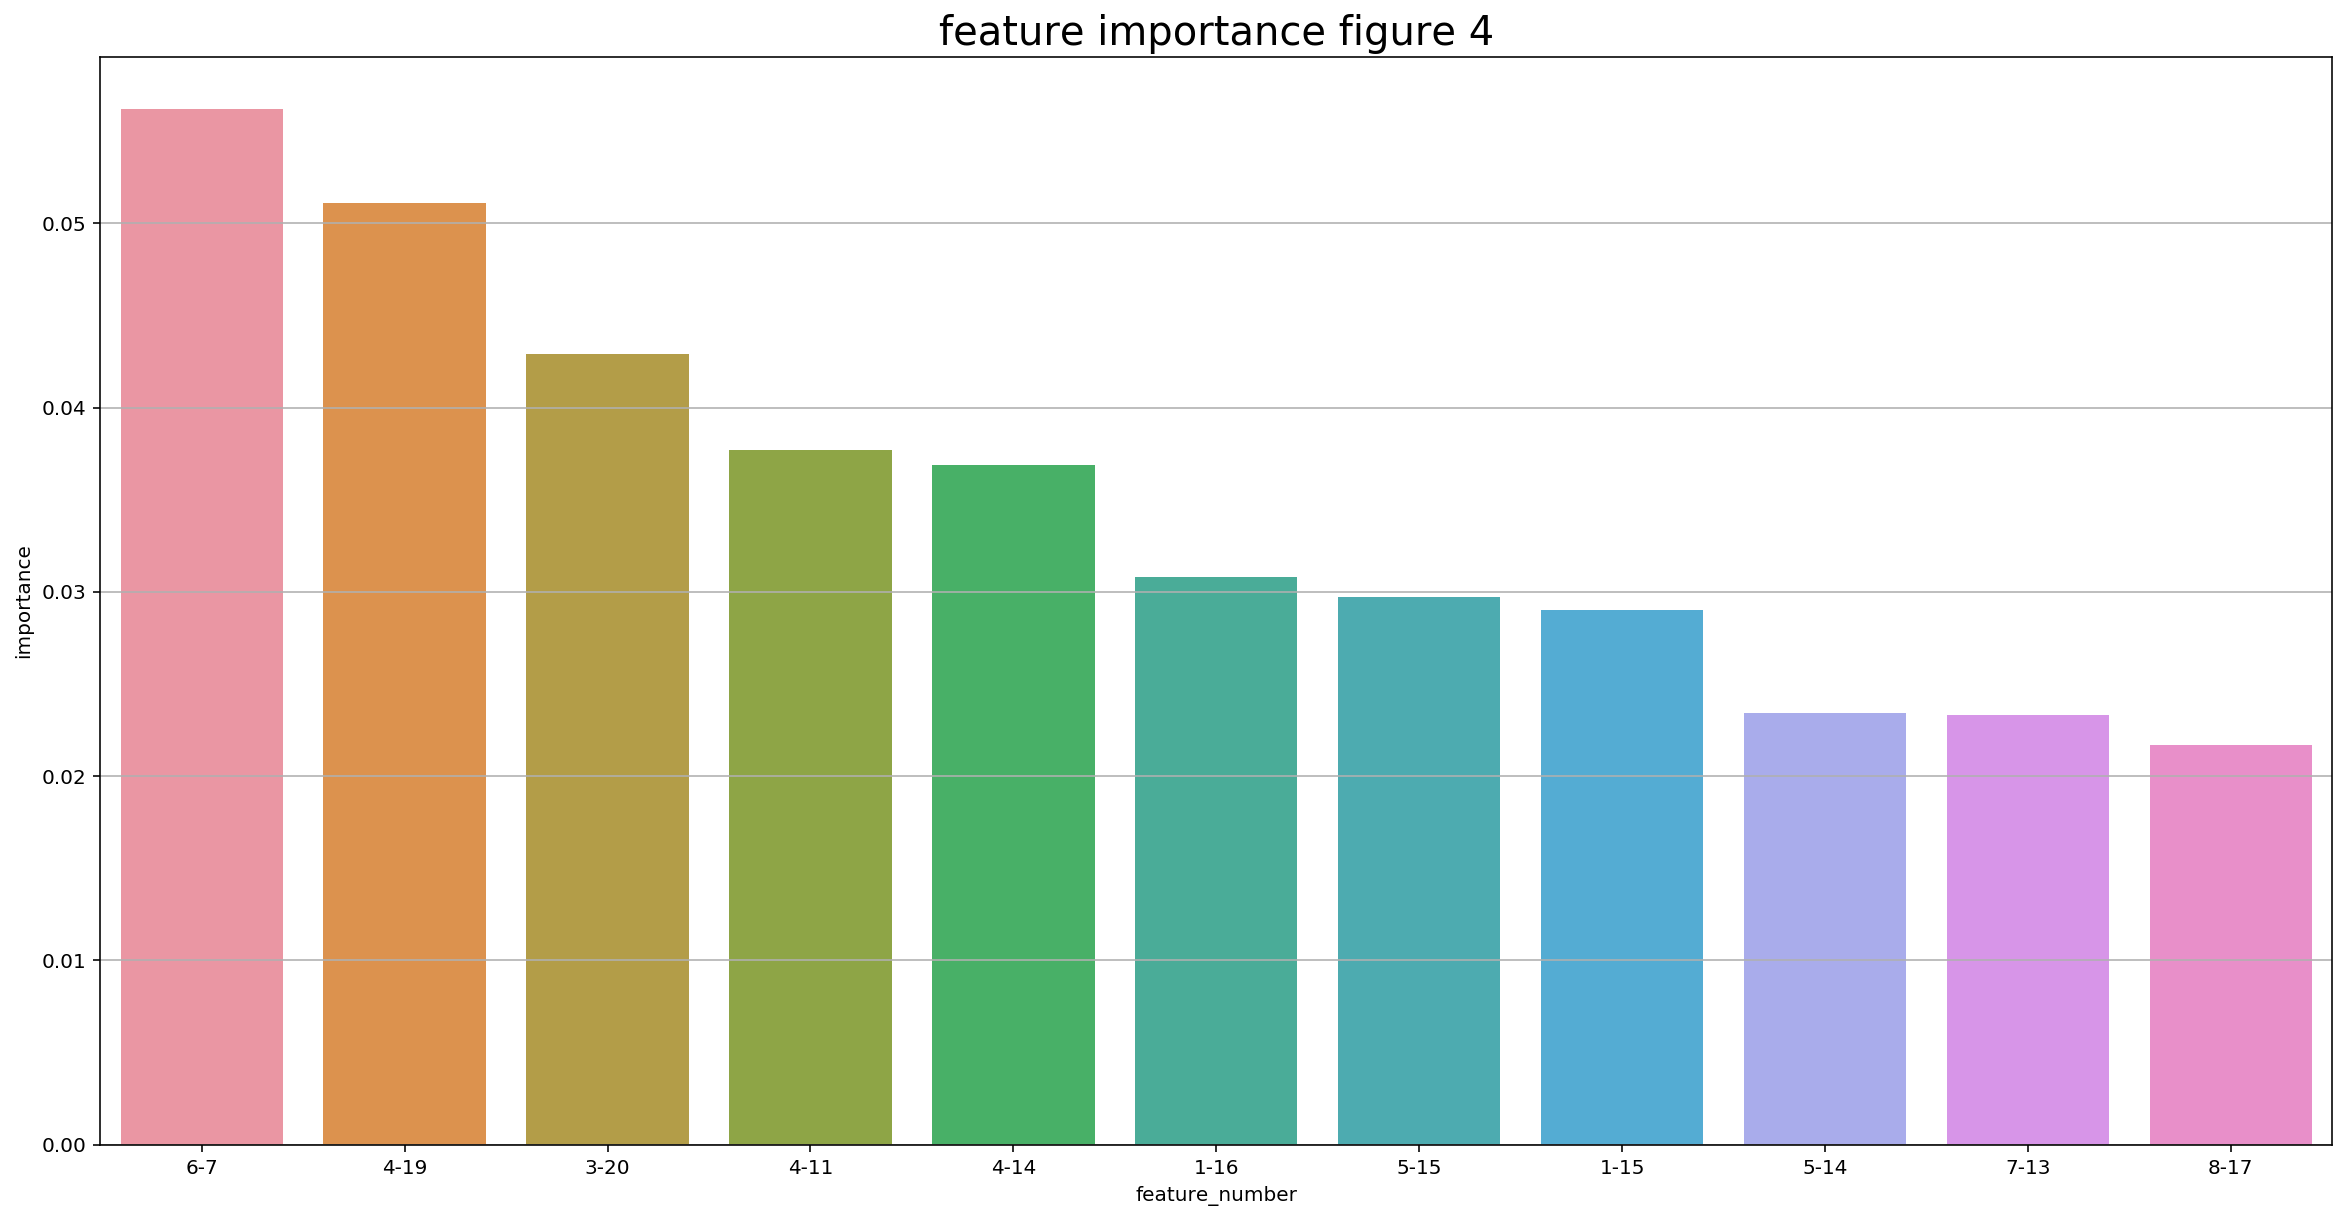

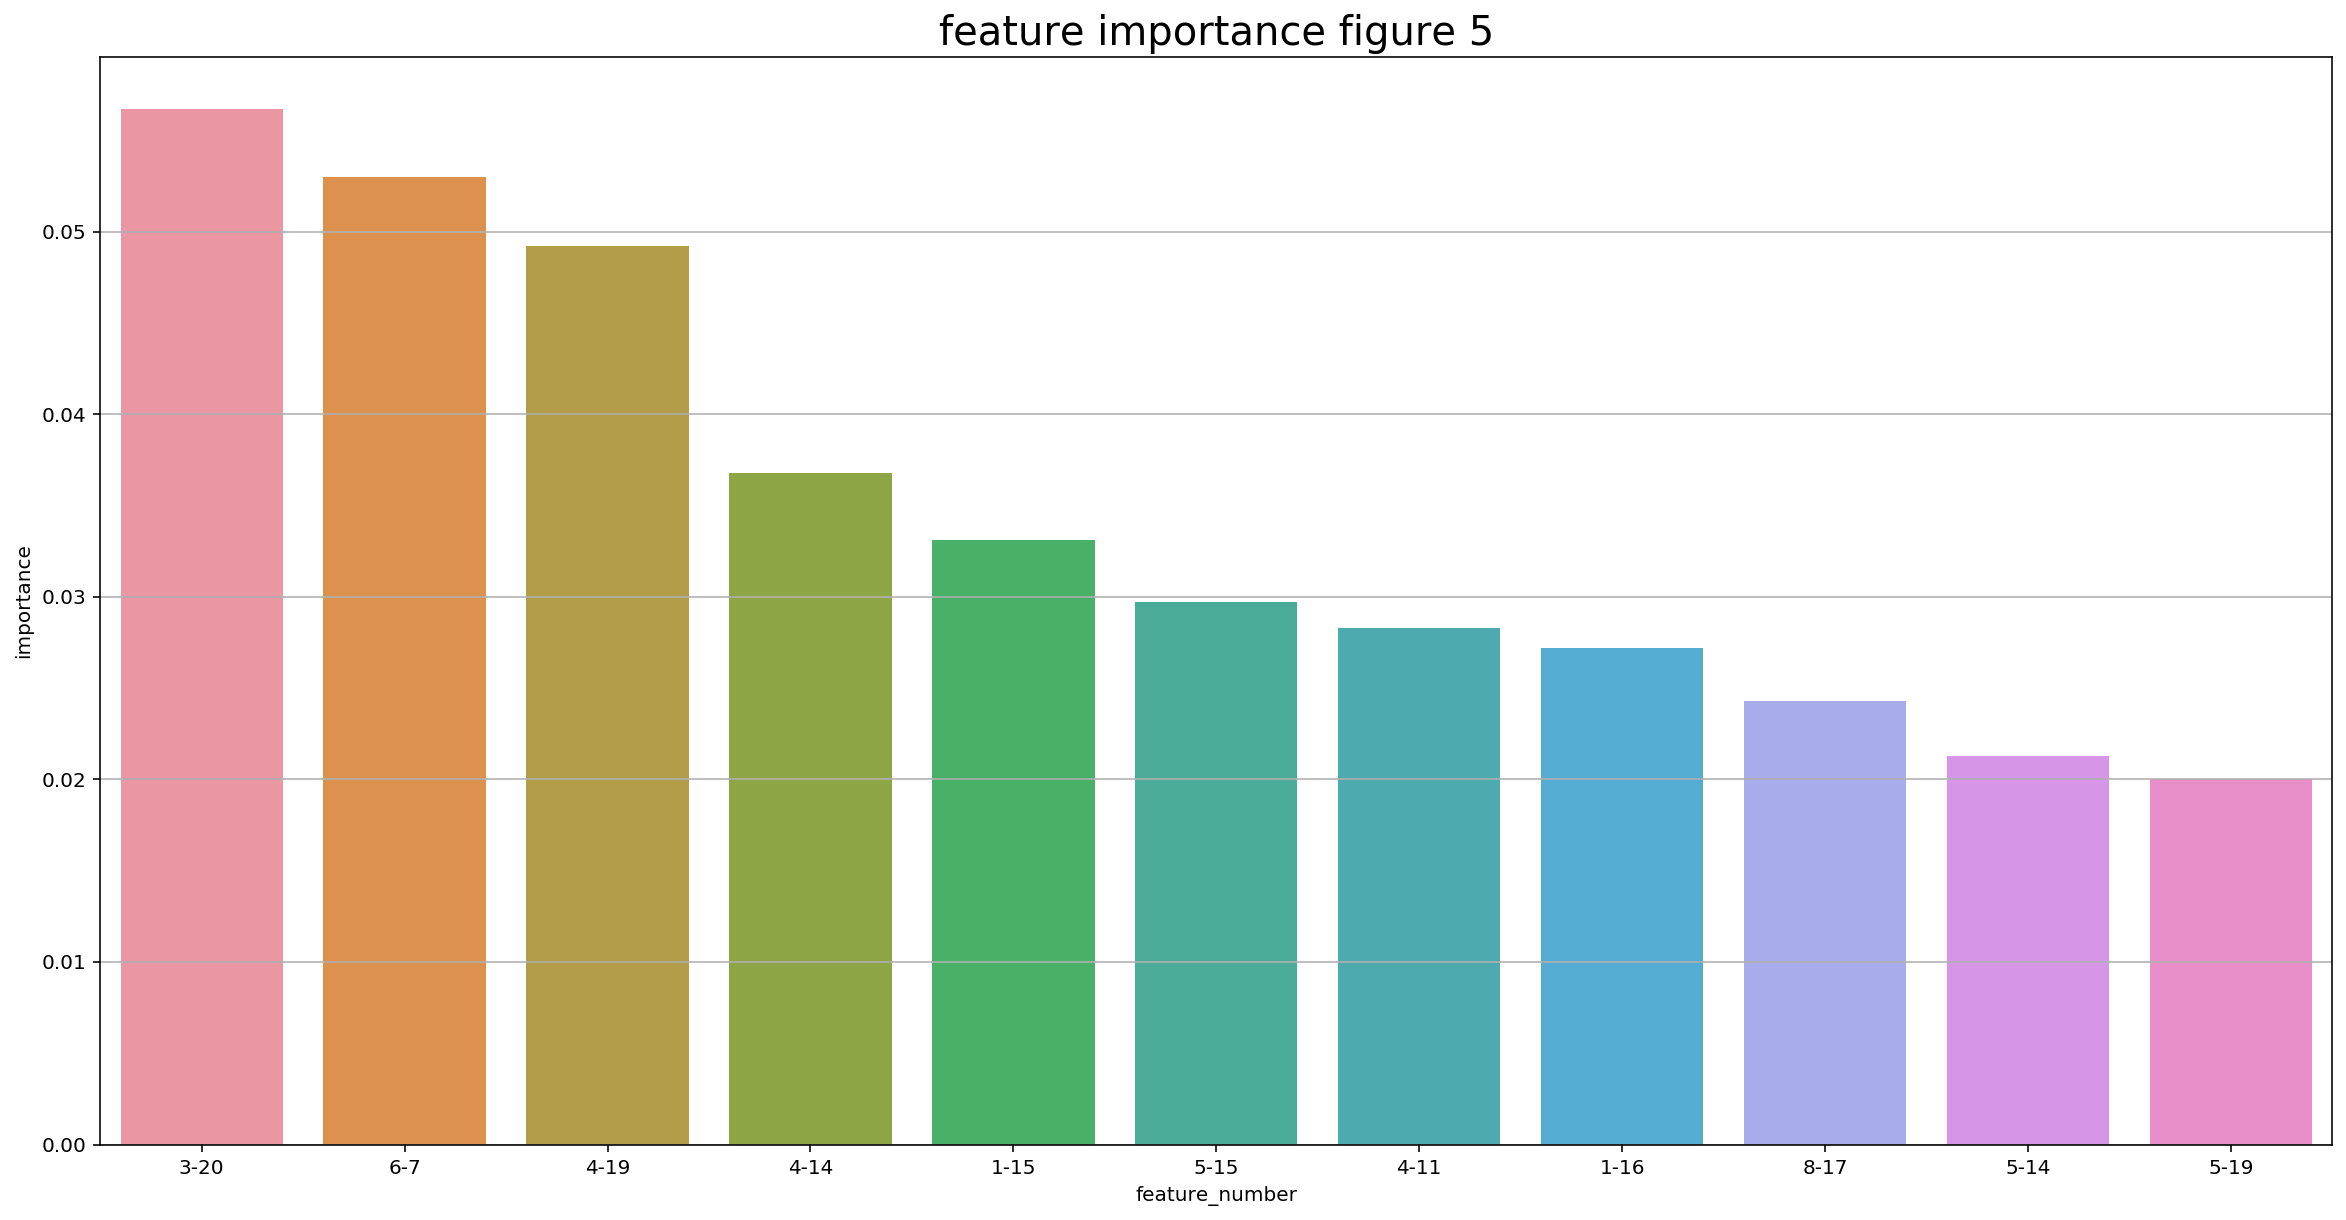

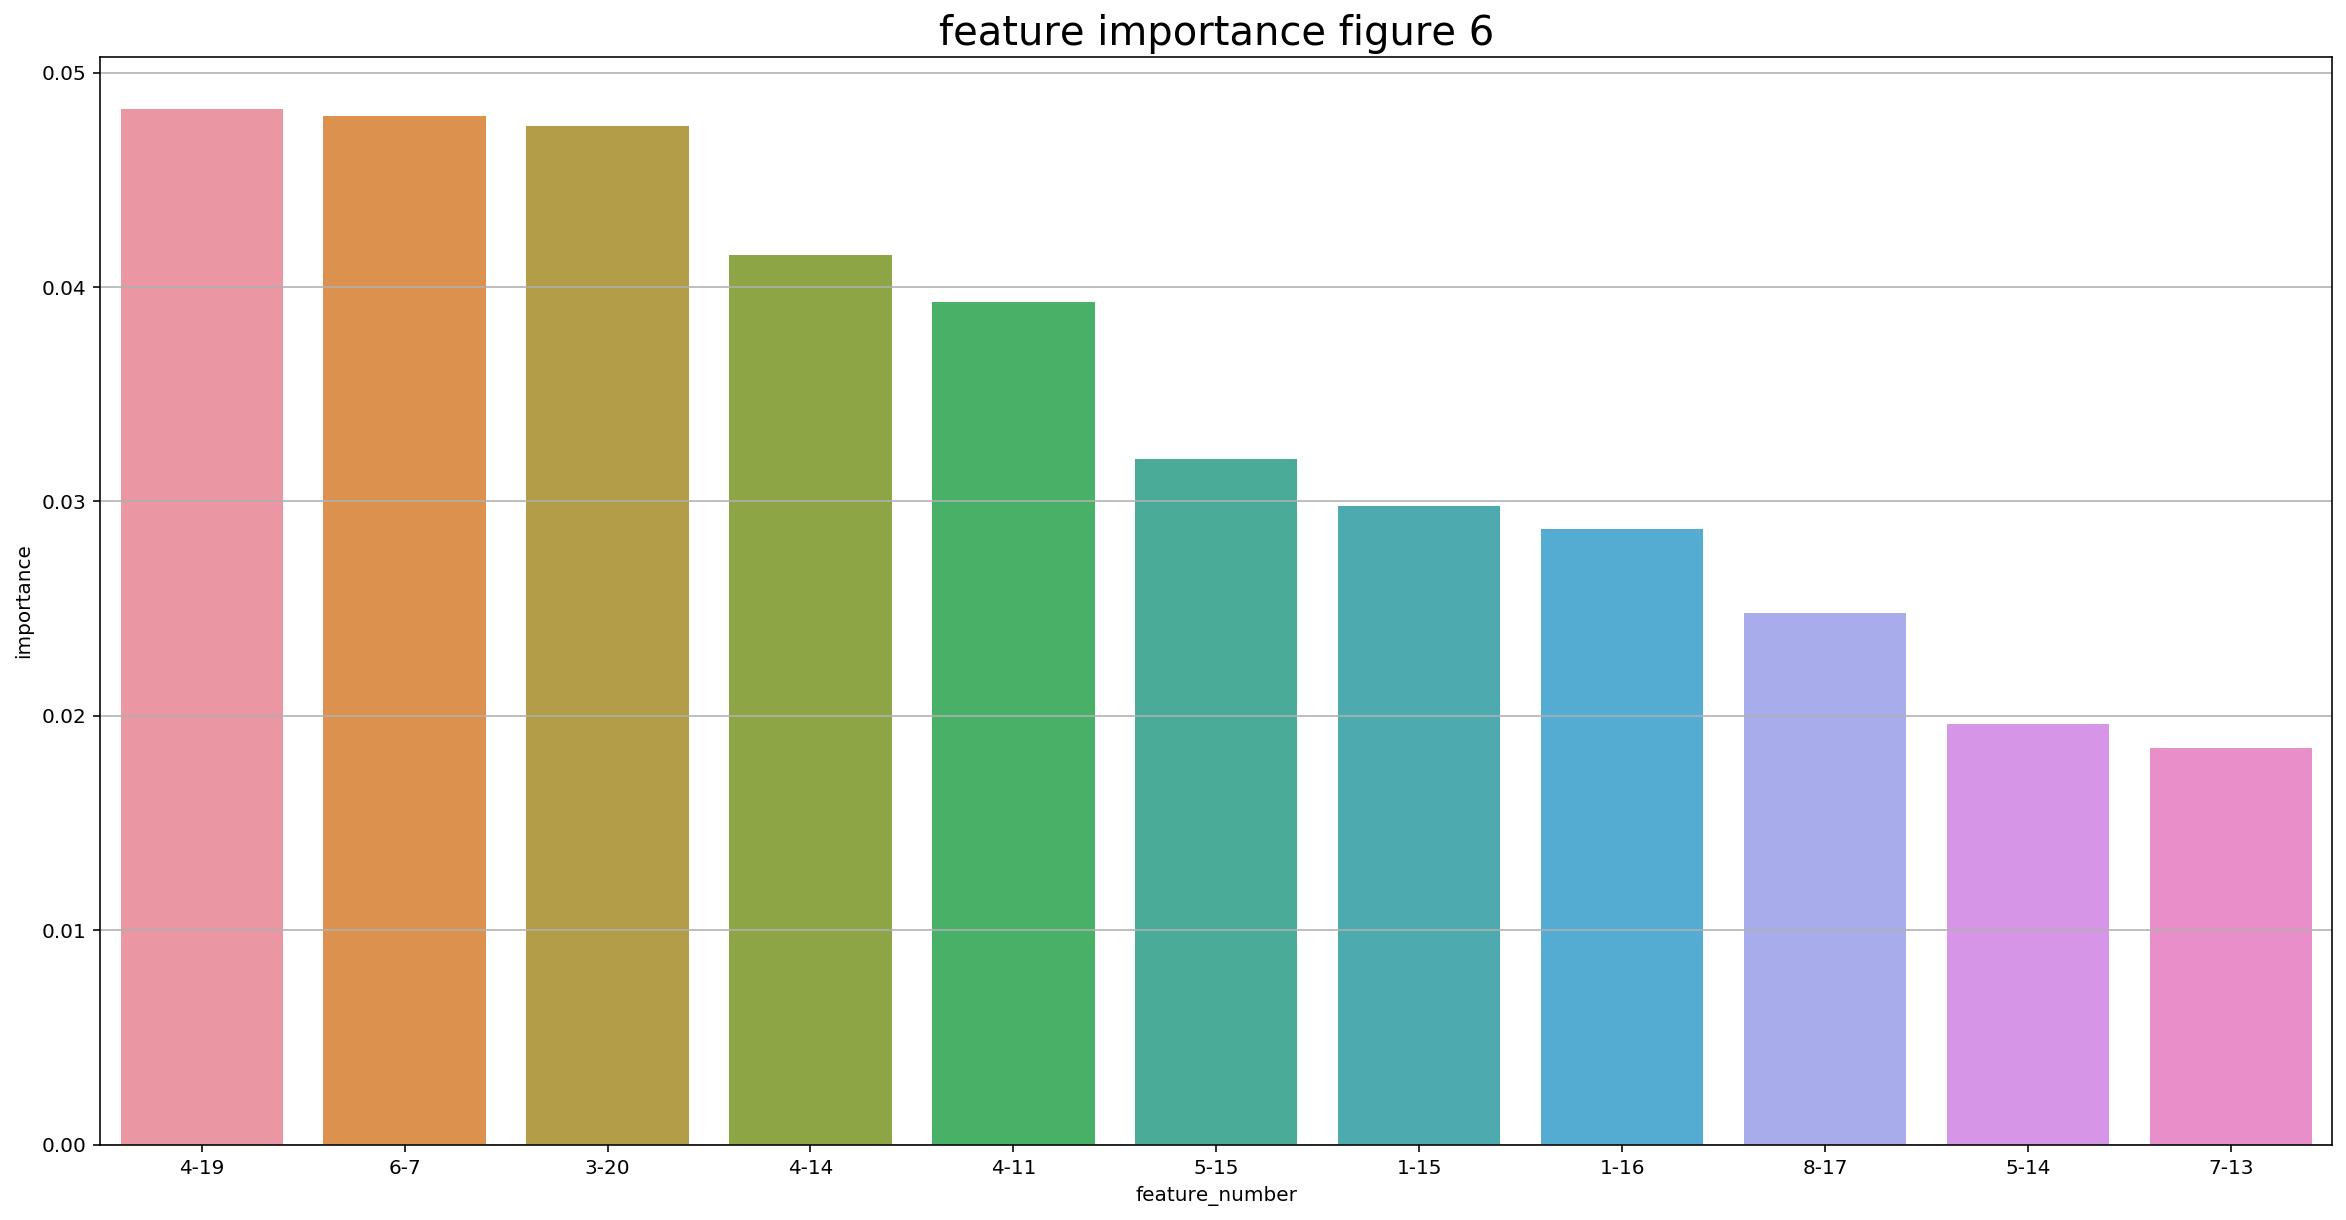

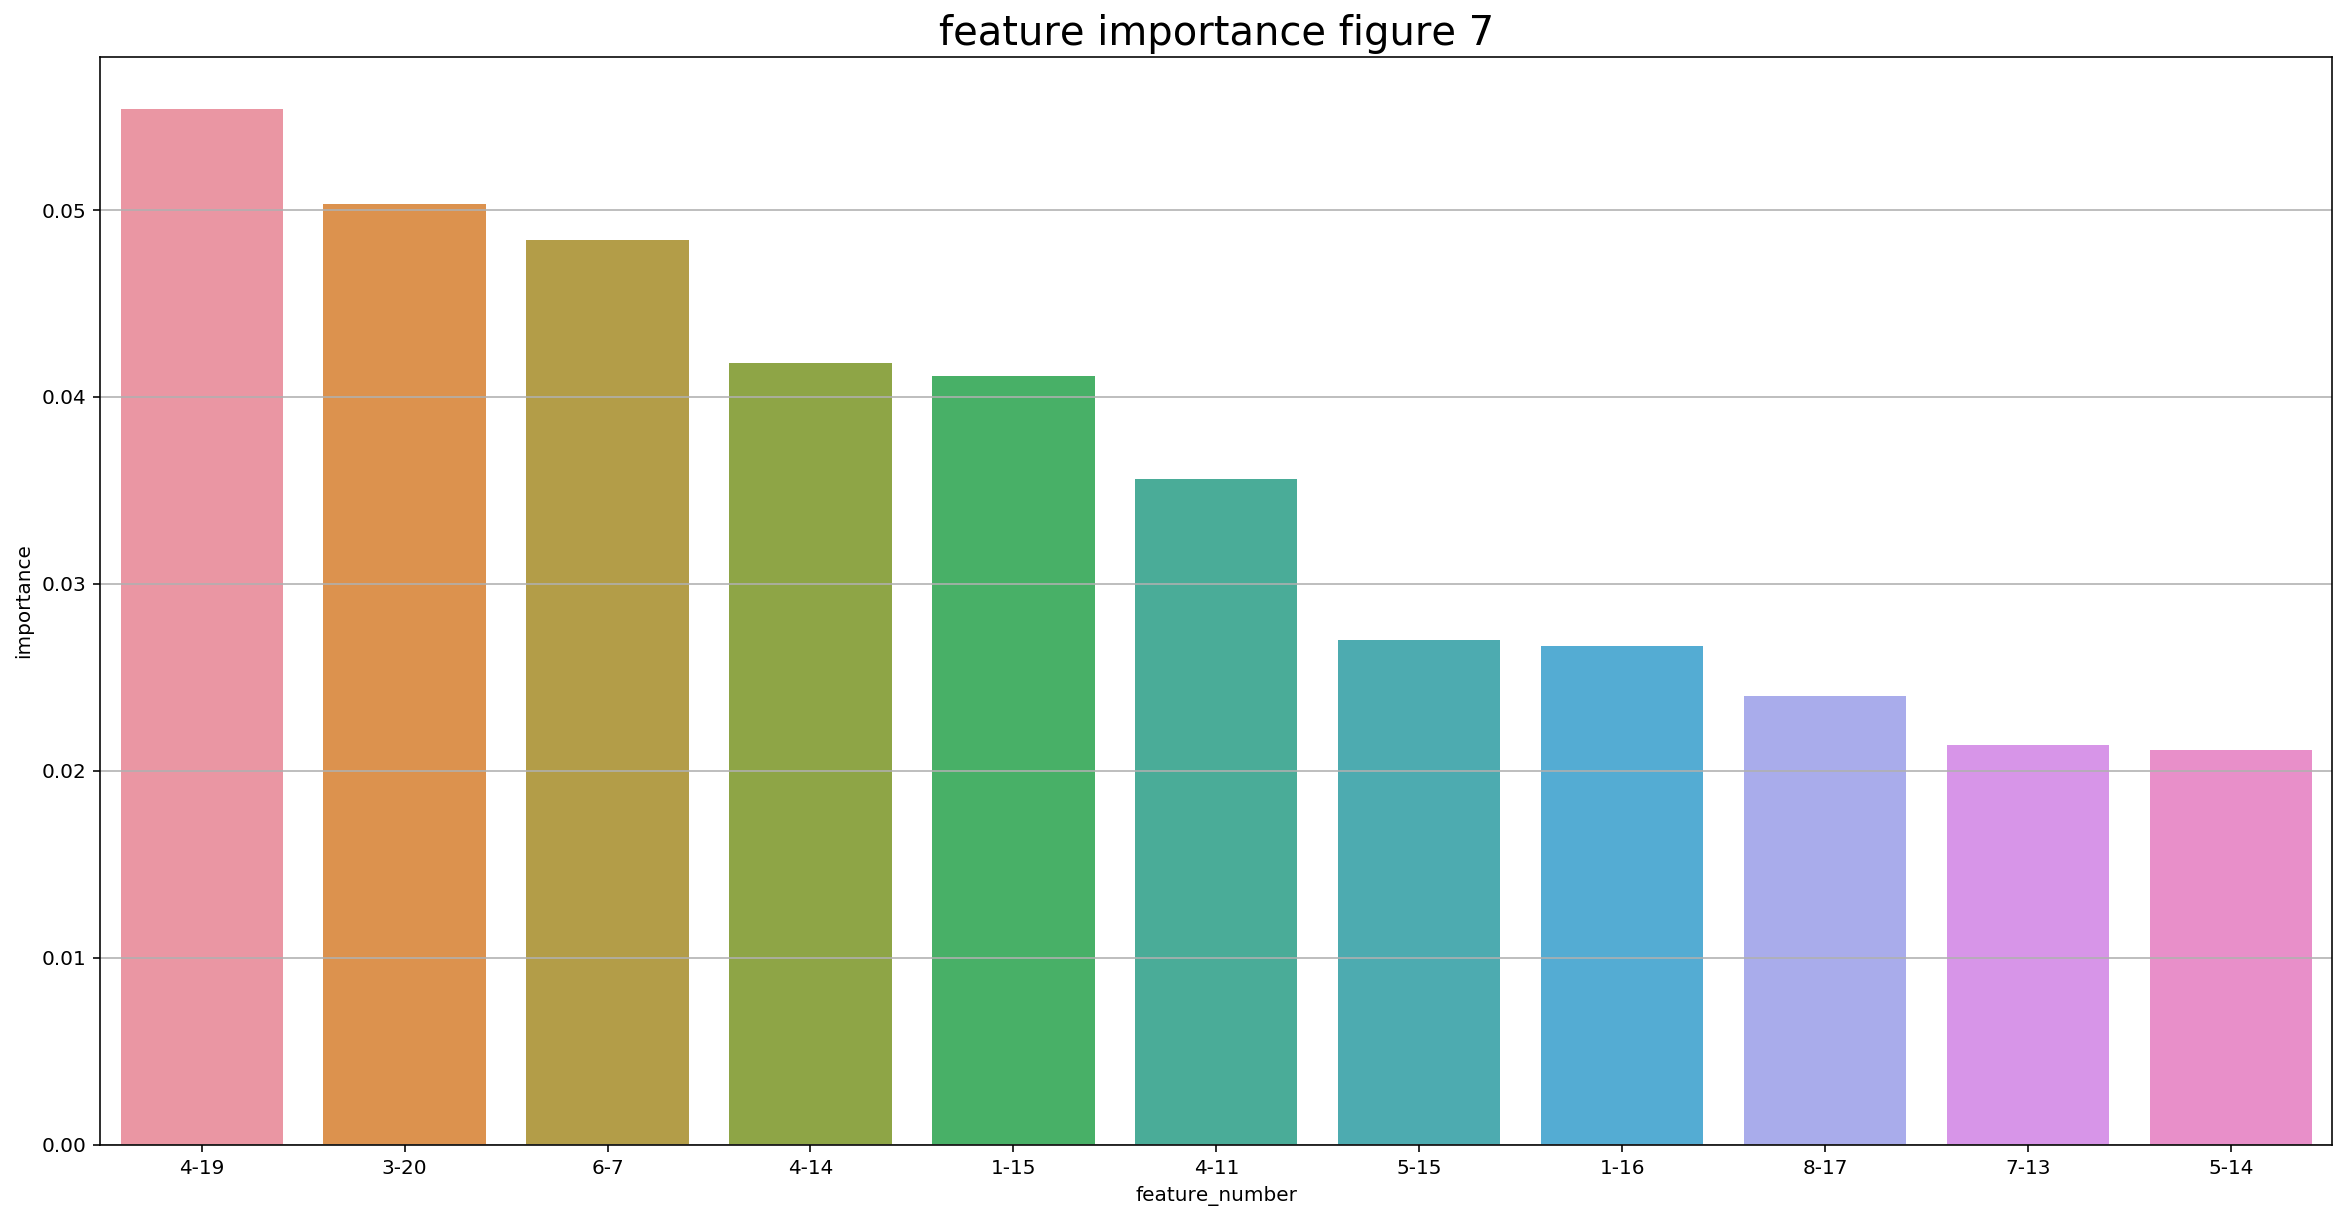

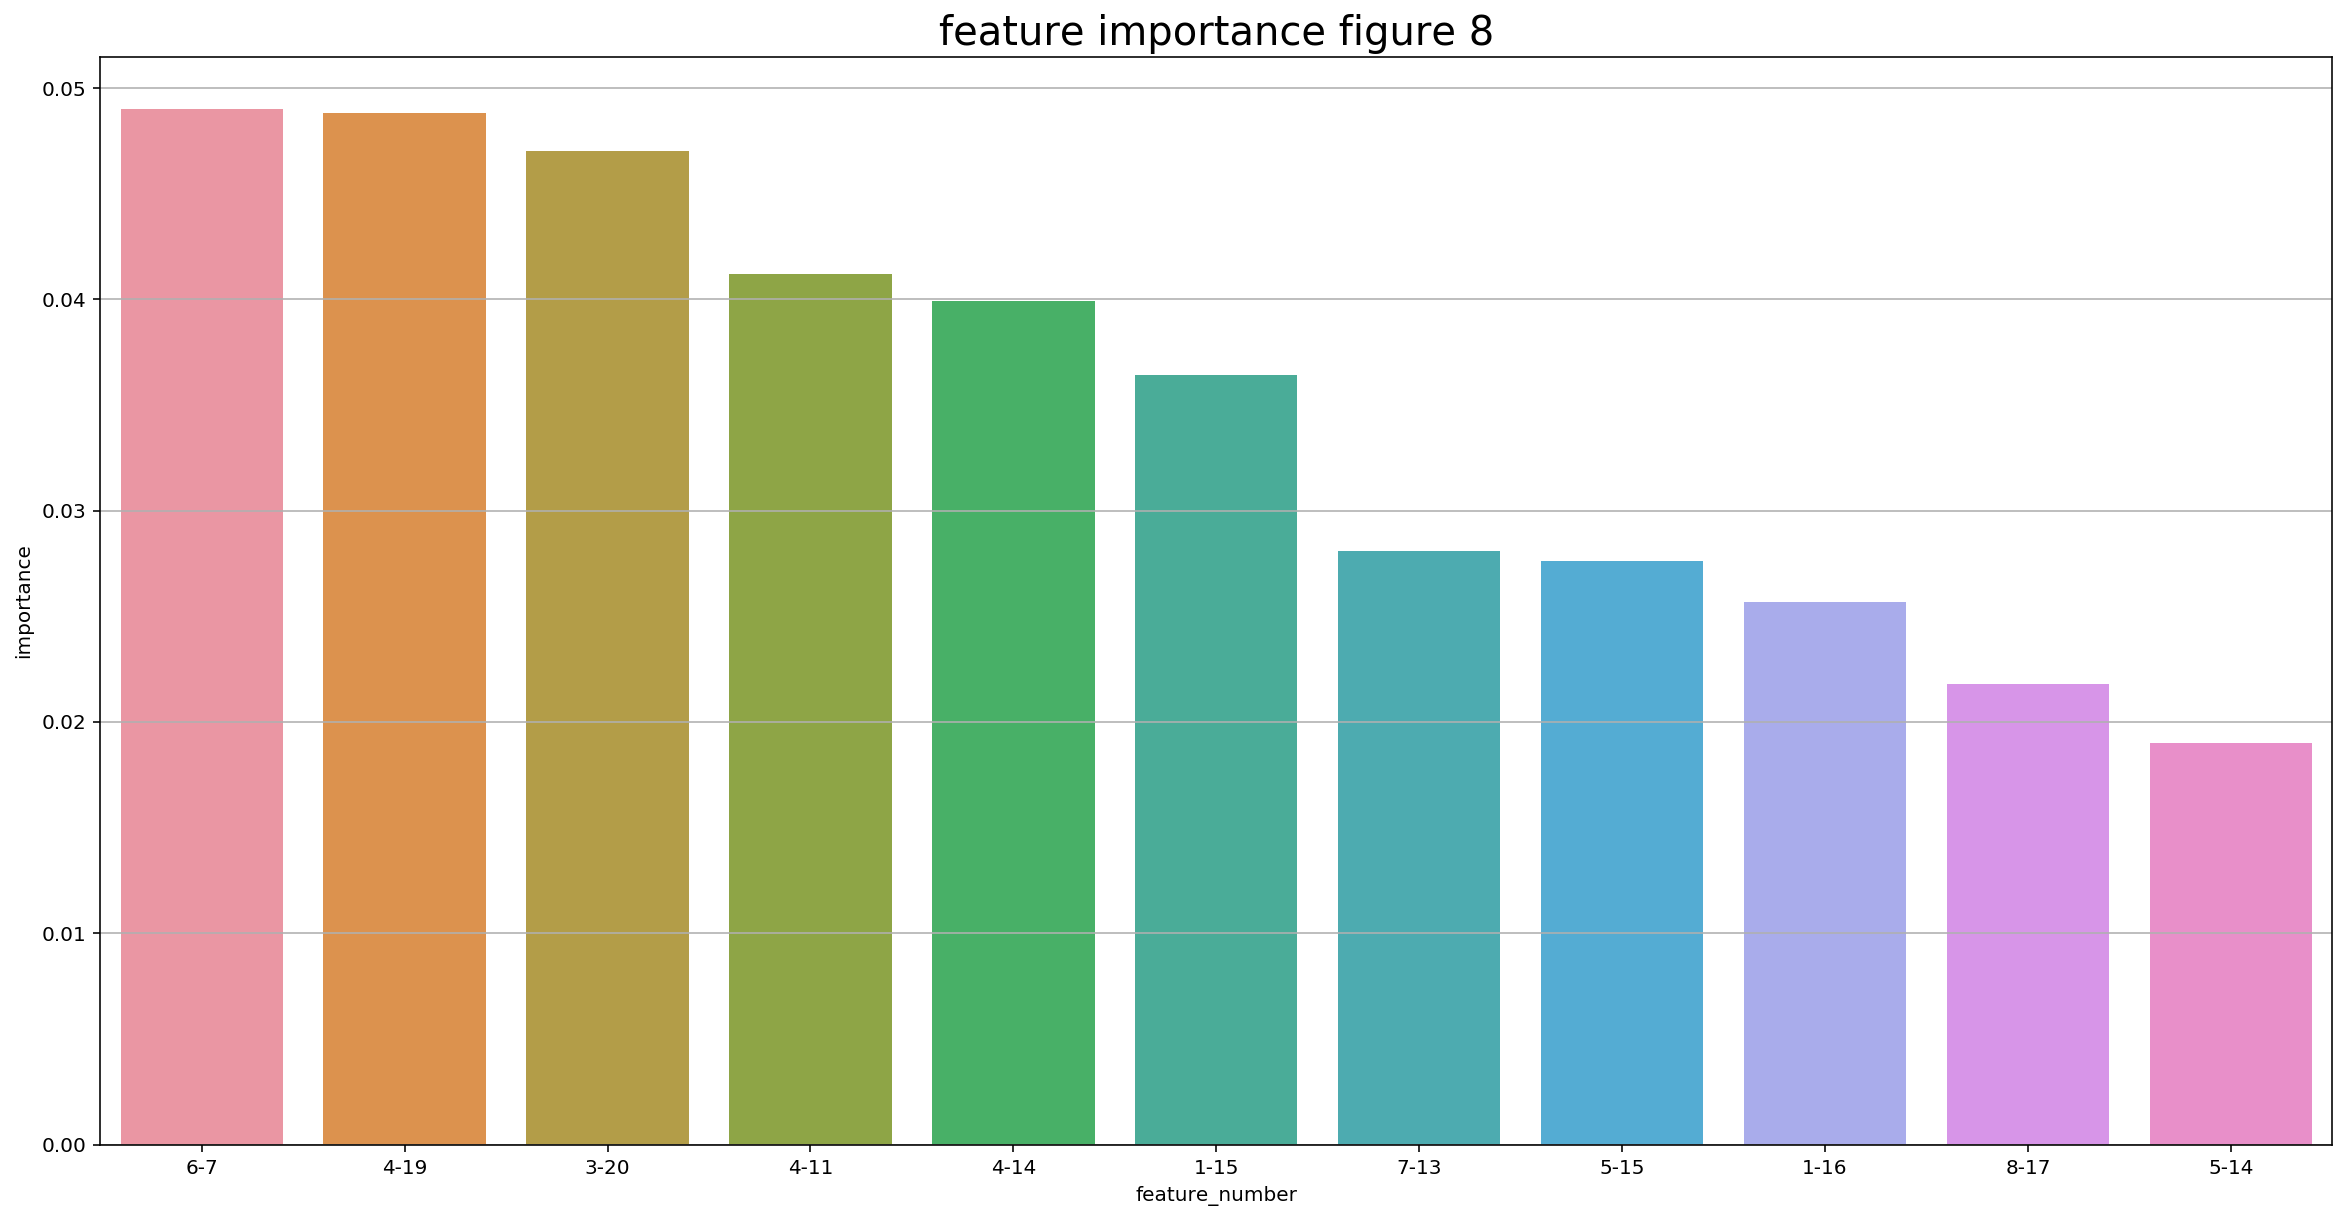

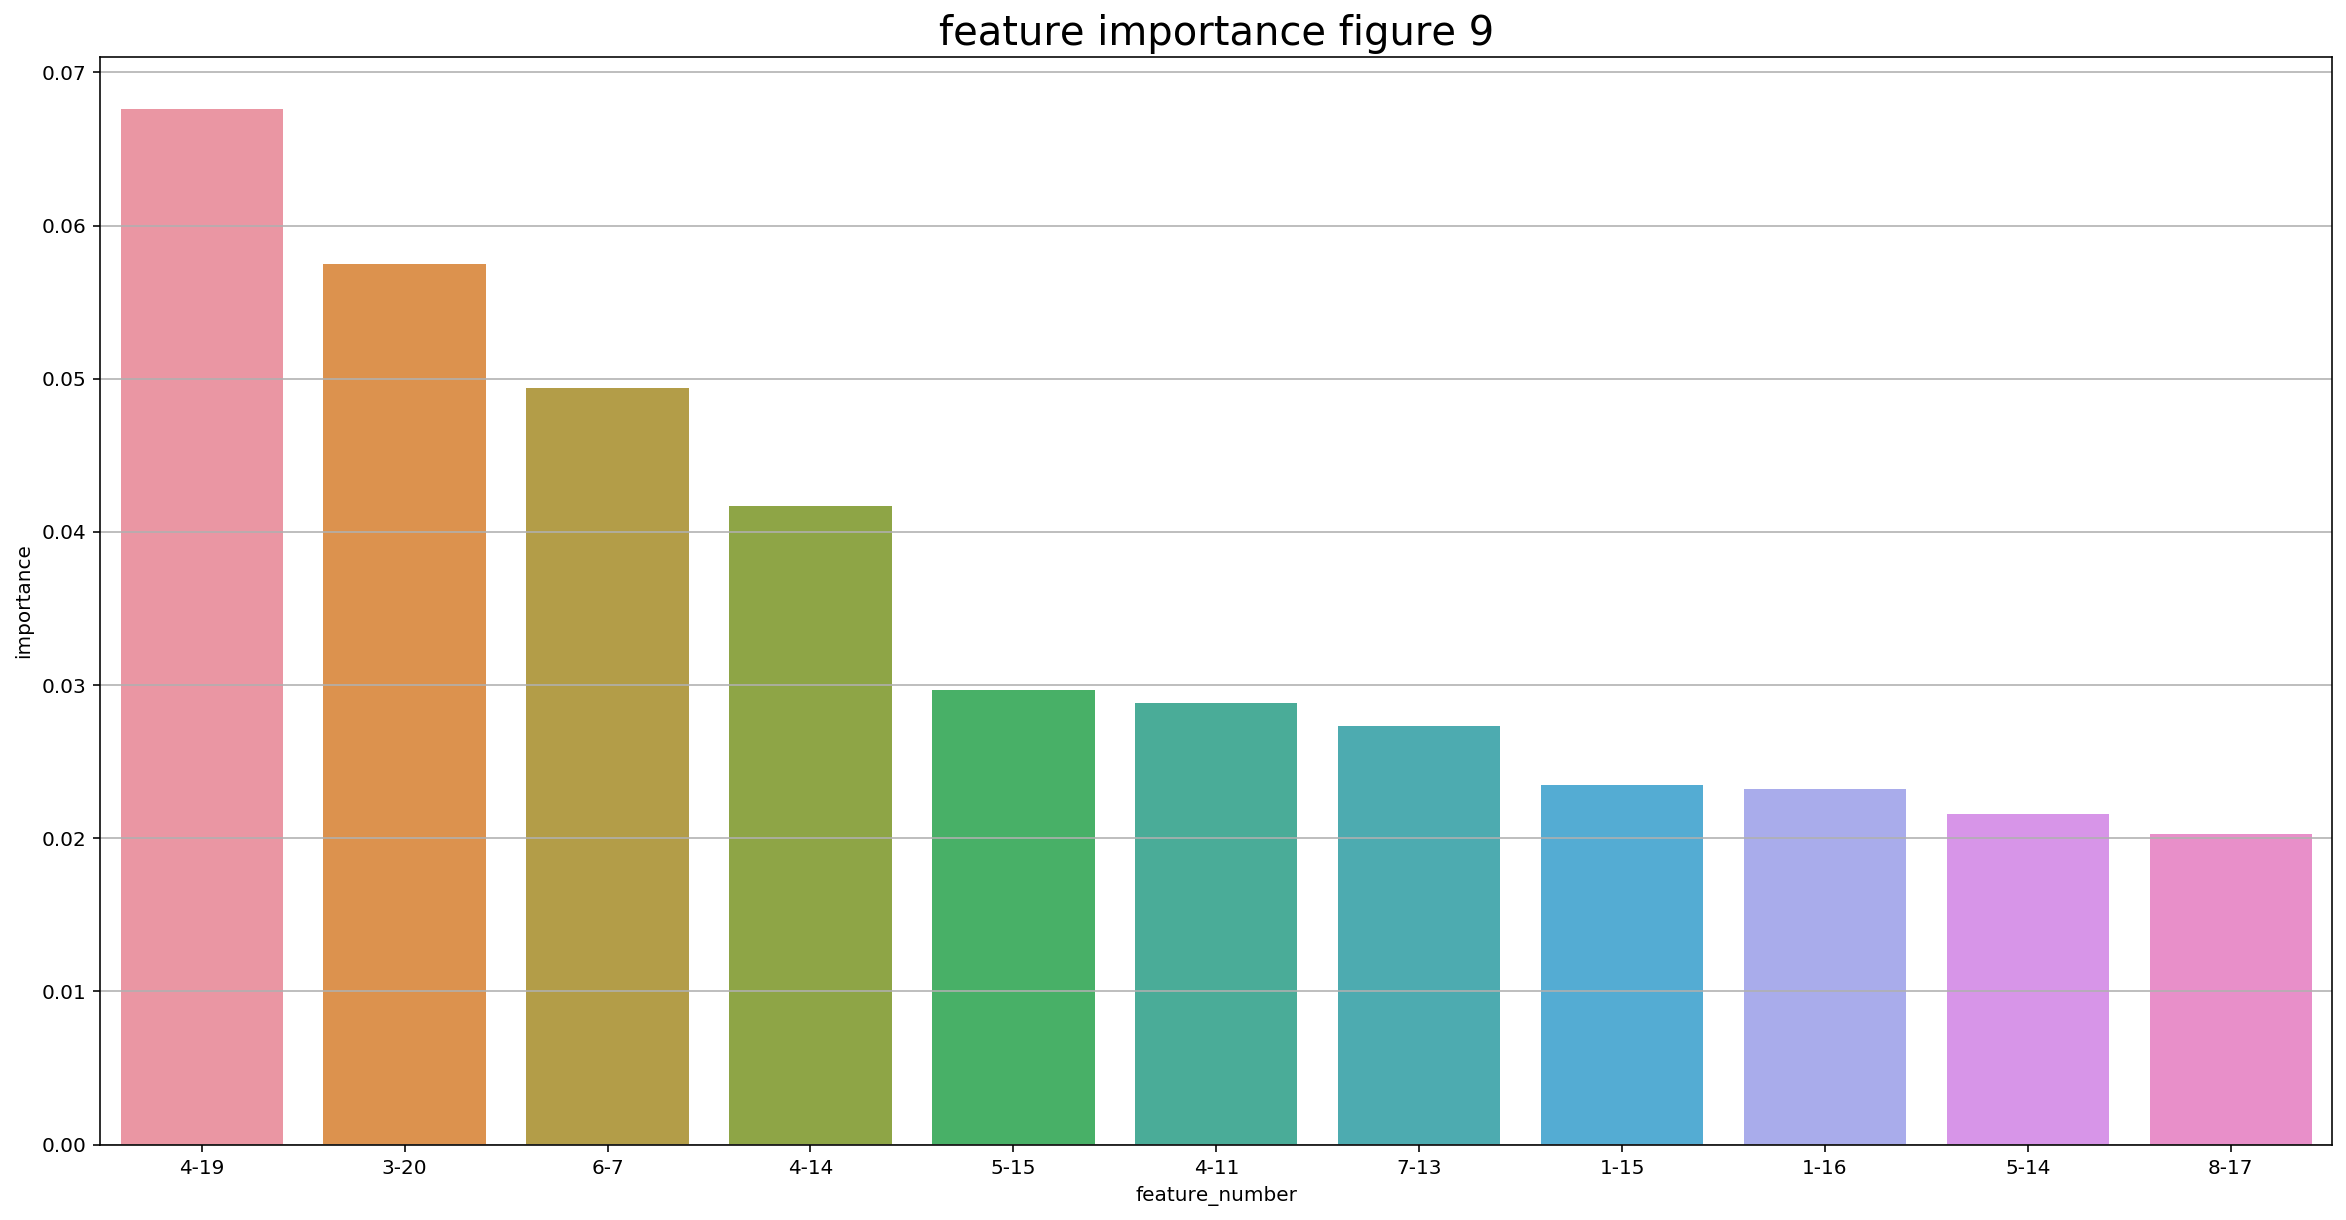

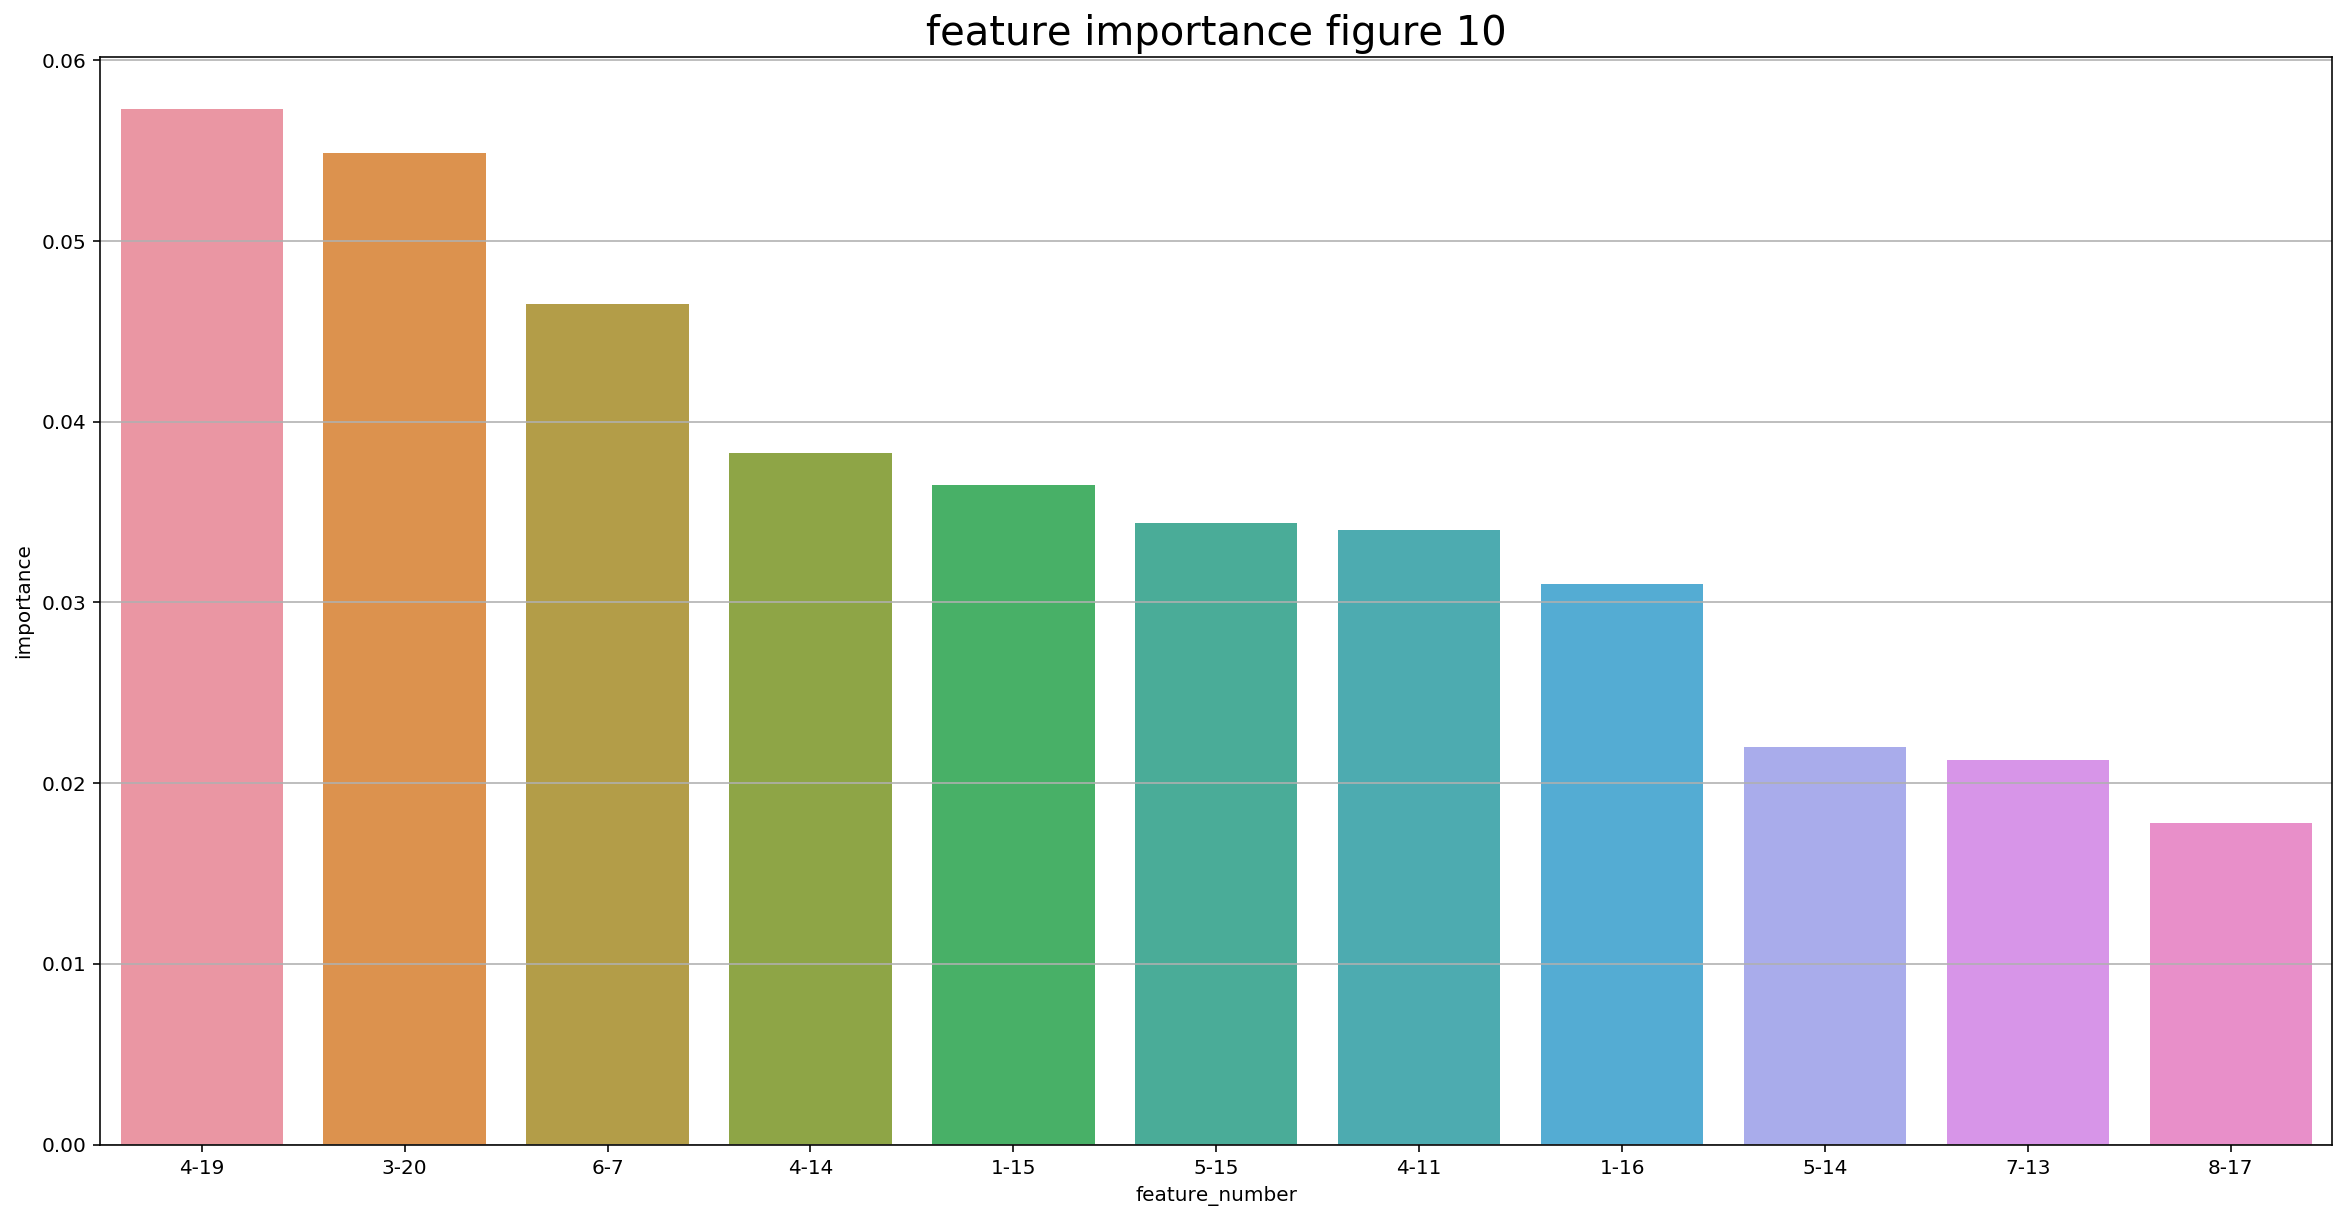

In [29]:

training_set = '765'
for i in range(10):
    feature_importance = random_forest_importance(training_set, data_set, data_dict_x, data_dict_y)
    importance_list = sorted(zip(map(lambda x: round(x, 4), feature_importance), feature_names),  reverse=True)
    importance_x = [n[1] for n in importance_list]
    importance_y = [m[0] for m in importance_list]
    fig = plt.figure(figsize=(20, 10))
    ax = plt.subplot(111)
    plt.grid()
    sns.barplot(x=importance_x[:11], y=importance_y[:11])
    ax.set_title('feature importance figure '+str(i+1), fontsize=20)
    ax.set_xlabel('feature_number')
    ax.set_ylabel('importance')

#### 重要性分析
图像表明数据特征第3维是否为V和第4维是否为Y对分类结果影响较大。

## 实验总结
- 这次没有手写出随机森林的代码，总结还是对于集成类算法原理的不熟悉。
- 这次主要做了通过网格搜索法调整模型参数，将特征重要性可视化出来的操作。
- 随机森林整体上效果要比logistic回归算法好。过程中的充分随机性保证了模型的鲁棒性。
- 在三个参数(max_features, n_estimators, min_sample_leaf)上调优。
- 可视化了特征的重要性，在本任务中特征的重要性比较抽象。